# Restricted Boltzmann Machine - MNIST

## Imports

In [ ]:
import sys, datetime
import os

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA
!mkdir img

## Load data

In [ ]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#print(X_original.shape)

## Parameters

In [ ]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3 ###########SEE Pdf
# use (+1,-1) if SPINS, otherwise use bits (1,0), ising spins
SPINS=False  
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False


dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

In [ ]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()

def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] ########to fine grain set digits  CHOSEN  7-8-9
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

In [ ]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [ ]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [ ]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [ ]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [ ]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

In [ ]:
import numpy as np
import itertools as it

#This code has been optimized with the help of chatGPT 4o. It is now clear the importance of using numpy array instead of lists when dealing with repeated operations, and that appending to a vector is 
# not optimized, instead is better to initialize a scalar and accumulate to it. Also important to do all possible operations outside of loops.

def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)

def compute_log_likelihood(partition,data, a, b, w):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(z) for z in all_conf])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, all_conf):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.log(Z_x) - partition

    return np.mean(log_likelihoods)

def H(z):  
    return a + np.dot(w, z)  

def G(z):  
    return np.prod(np.exp(b * z))

def partition_function():
    all_conf = generate_configurations(L)
    sum_values = 0.0  # Use scalar accumulation

    for z in all_conf:
        Hz = H(z)
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(z) * produttoria_H

    return np.log(sum_values)


### RBM TRAIN

Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

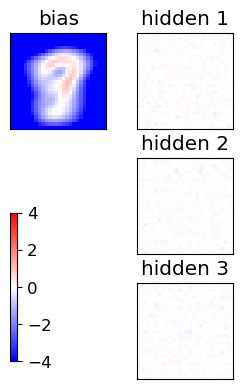

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[14609 20489 19353 12483  5959  6641  3256  8691 13776 18598]
[20879 13132  6733  5221  4001  7460  9087  6643 13589 16863]
[16399  8664  7803 17156 11238  7008  2484 17783 20074 15474]
epoch 1 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -173.90762293157474
epoch 6 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 2  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

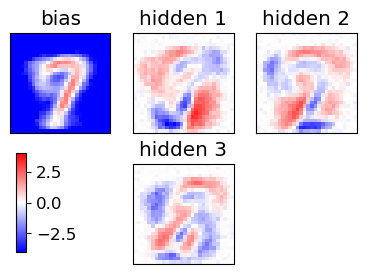

Epoch 21, Log-Likelihood: -163.04896247565372
epoch 21 / 150  Nt: 2  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 2  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 2  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 2  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 2  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -167.2580238857548
epoch 26 / 150  Nt: 2  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 2  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 2  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 2  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 2  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -161.82520387465772
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

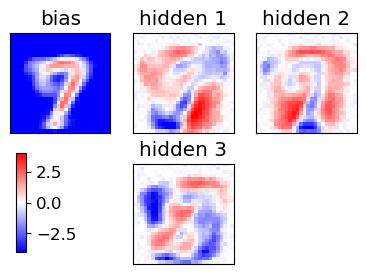

Epoch 41, Log-Likelihood: -161.82205088530714
epoch 41 / 150  Nt: 2  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 2  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 2  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 2  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 2  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -162.4816634078008
epoch 46 / 150  Nt: 2  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 2  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 2  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 2  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 2  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -162.18805251387067
epoch 51 / 15

<Figure size 640x480 with 0 Axes>

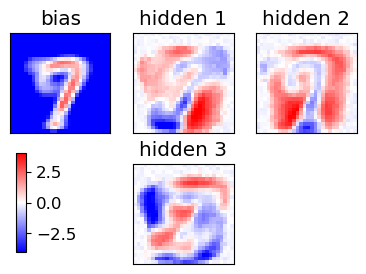

Epoch 61, Log-Likelihood: -160.87441161009795
epoch 61 / 150  Nt: 2  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 2  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 2  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 2  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 2  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -160.41535158515194
epoch 66 / 150  Nt: 2  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 2  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 2  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 2  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 2  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -160.97117819730988
epoch 

<Figure size 640x480 with 0 Axes>

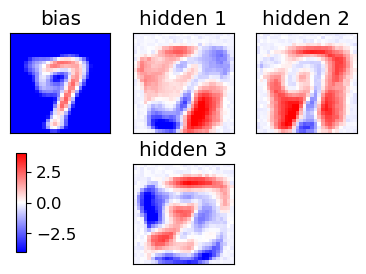

Epoch 81, Log-Likelihood: -162.95390960794262
epoch 81 / 150  Nt: 2  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 2  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 2  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 2  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 2  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -160.1414484023012
epoch 86 / 150  Nt: 2  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 2  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 2  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 2  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 2  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -161.19864554892914
epo

<Figure size 640x480 with 0 Axes>

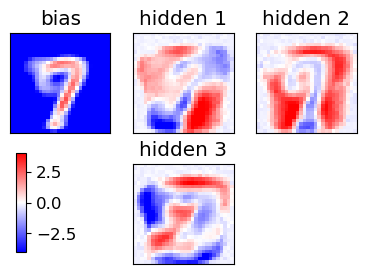

Epoch 101, Log-Likelihood: -159.89603457351527
epoch 101 / 150  Nt: 2  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 2  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 2  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 2  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 2  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -161.7366201186616
epoch 106 / 150  Nt: 2  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 2  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 2  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 2  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 2  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -162.13918

<Figure size 640x480 with 0 Axes>

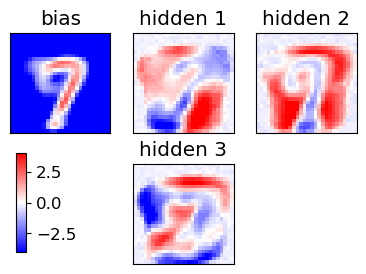

Epoch 121, Log-Likelihood: -160.5813800187403
epoch 121 / 150  Nt: 2  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 2  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 2  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 2  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 2  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -160.60400228103805
epoch 126 / 150  Nt: 2  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 2  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 2  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 2  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 2  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -161.01708

<Figure size 640x480 with 0 Axes>

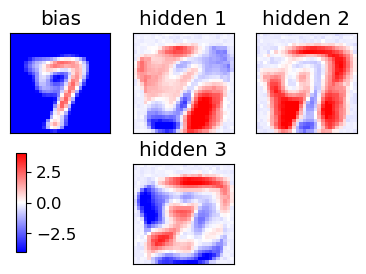

Epoch 141, Log-Likelihood: -163.2204668449819
epoch 141 / 150  Nt: 2  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 2  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 2  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 2  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 2  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -164.35018667939866
epoch 146 / 150  Nt: 2  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 2  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 2  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 2  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 2  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

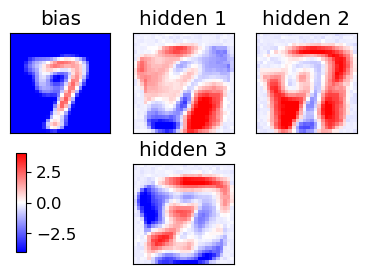

Epoch 151, Log-Likelihood: -160.87213793502804


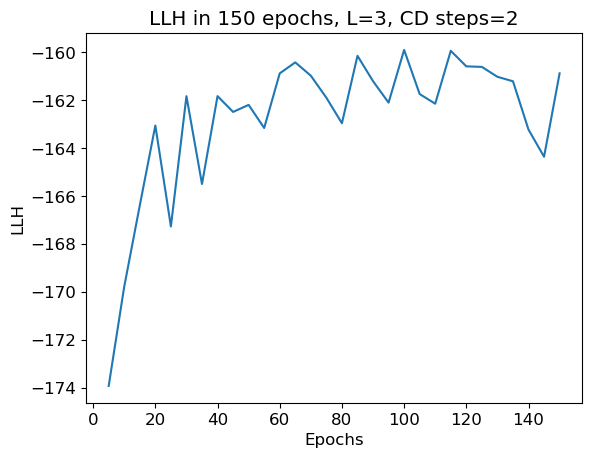

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

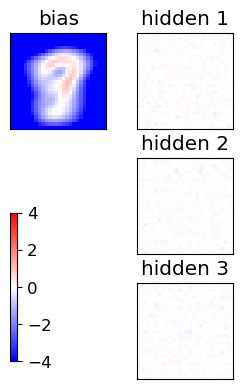

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[17459 14234  2839 18206 19454 15697  1509  3053 10101 14982]
[16899 10881 19728 19952  4473  1673  1294   581 13053  7910]
[10363 13646  4421 11030 17342 14866 14777  2891 17880  6534]
epoch 1 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -169.2539438943107
epoch 6 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 4  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 4  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150 

<Figure size 640x480 with 0 Axes>

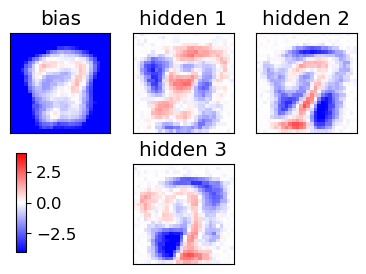

Epoch 21, Log-Likelihood: -165.68133483932866
epoch 21 / 150  Nt: 4  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 4  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 4  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 4  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 4  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -167.11772844077842
epoch 26 / 150  Nt: 4  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 4  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 4  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 4  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 4  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -162.73151210359268
epoch 31 / 1

<Figure size 640x480 with 0 Axes>

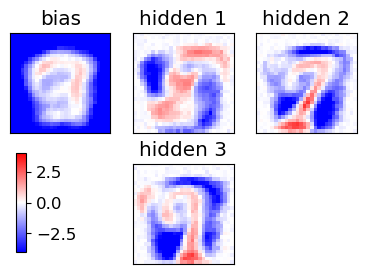

Epoch 41, Log-Likelihood: -164.0075559005984
epoch 41 / 150  Nt: 4  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 4  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 4  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 4  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 4  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -163.608909439809
epoch 46 / 150  Nt: 4  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 4  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 4  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 4  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 4  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -163.8773478682131
epoch 51 / 150  

<Figure size 640x480 with 0 Axes>

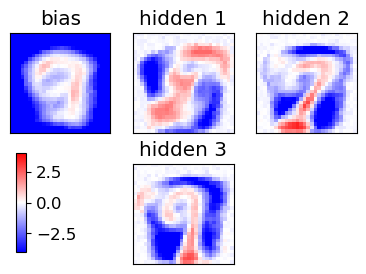

Epoch 61, Log-Likelihood: -166.24758535238678
epoch 61 / 150  Nt: 4  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 4  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 4  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 4  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 4  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -164.77208402032542
epoch 66 / 150  Nt: 4  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 4  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 4  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 4  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 4  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -163.08348642694278
epoch 

<Figure size 640x480 with 0 Axes>

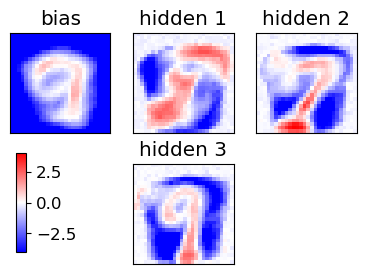

Epoch 81, Log-Likelihood: -165.17182474278118
epoch 81 / 150  Nt: 4  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 4  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 4  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 4  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 4  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -163.48645991008502
epoch 86 / 150  Nt: 4  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 4  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 4  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 4  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 4  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -164.84889009099473
ep

<Figure size 640x480 with 0 Axes>

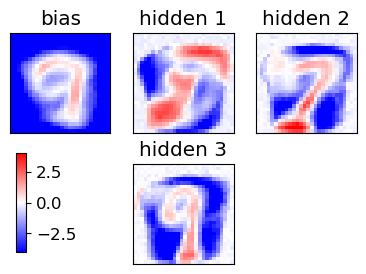

Epoch 101, Log-Likelihood: -164.16013837620636
epoch 101 / 150  Nt: 4  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 4  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 4  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 4  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 4  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -164.72773532275454
epoch 106 / 150  Nt: 4  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 4  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 4  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 4  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 4  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -164.6511

<Figure size 640x480 with 0 Axes>

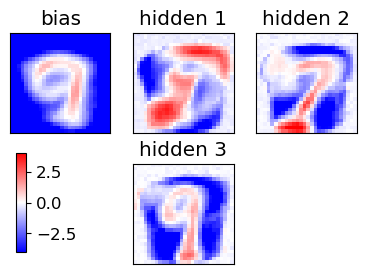

Epoch 121, Log-Likelihood: -164.07101156461238
epoch 121 / 150  Nt: 4  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 4  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 4  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 4  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 4  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -163.94505734171287
epoch 126 / 150  Nt: 4  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 4  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 4  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 4  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 4  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -163.6252

<Figure size 640x480 with 0 Axes>

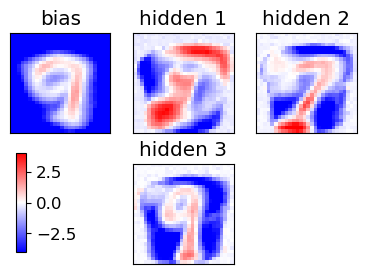

Epoch 141, Log-Likelihood: -165.1384895713952
epoch 141 / 150  Nt: 4  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 4  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 4  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 4  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 4  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -164.93289413859043
epoch 146 / 150  Nt: 4  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 4  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 4  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 4  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 4  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

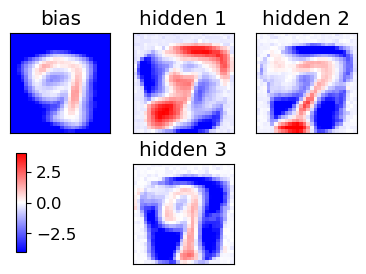

Epoch 151, Log-Likelihood: -165.10611215657602


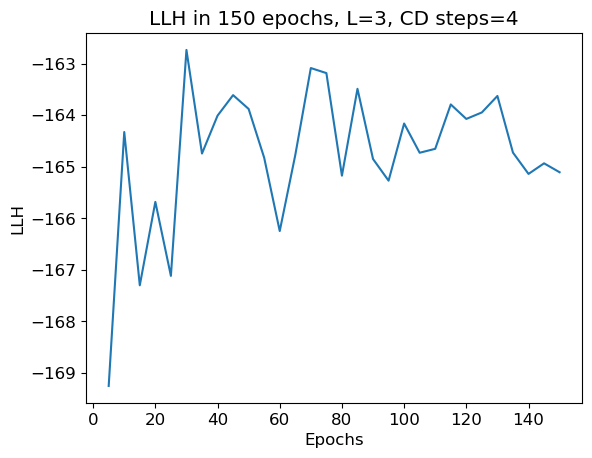

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

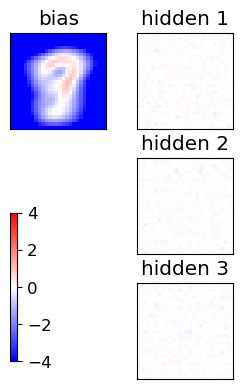

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[14856 12359  3666  5813  6745  2395 13113 10327 12506 19376]
[14550  3932 17766 13017  2104  9668 19176  4822 10461 15990]
[10536   594 18504  1985 13436 13944 17367 12179  3462 17225]
epoch 1 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -173.37456297574693
epoch 6 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 6  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 6  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

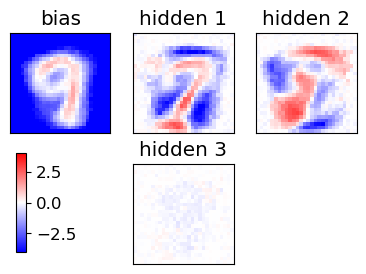

Epoch 21, Log-Likelihood: -171.2840622070221
epoch 21 / 150  Nt: 6  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 6  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 6  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 6  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 6  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -171.93507108001336
epoch 26 / 150  Nt: 6  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 6  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 6  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 6  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 6  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -169.66974603501194
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

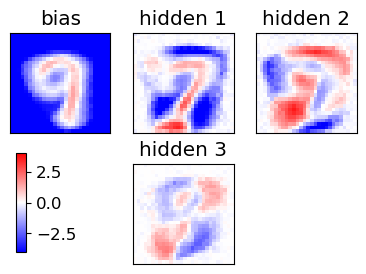

Epoch 41, Log-Likelihood: -168.620598601504
epoch 41 / 150  Nt: 6  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 6  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 6  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 6  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 6  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -165.34516304261183
epoch 46 / 150  Nt: 6  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 6  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 6  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 6  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 6  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -163.97538968572957
epoch 51 / 150

<Figure size 640x480 with 0 Axes>

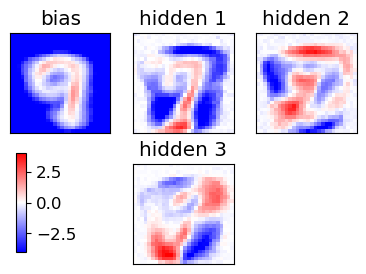

Epoch 61, Log-Likelihood: -164.98115328741827
epoch 61 / 150  Nt: 6  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 6  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 6  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 6  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 6  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -165.10224368765418
epoch 66 / 150  Nt: 6  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 6  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 6  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 6  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 6  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -161.810194882225
epoch 71

<Figure size 640x480 with 0 Axes>

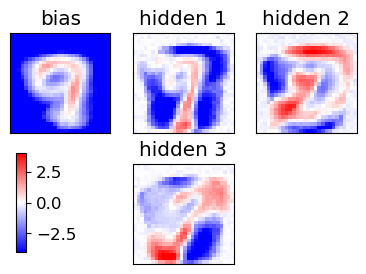

Epoch 81, Log-Likelihood: -163.9537426498505
epoch 81 / 150  Nt: 6  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 6  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 6  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 6  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 6  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -163.94277271392372
epoch 86 / 150  Nt: 6  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 6  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 6  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 6  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 6  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -163.0661209378476
epoc

<Figure size 640x480 with 0 Axes>

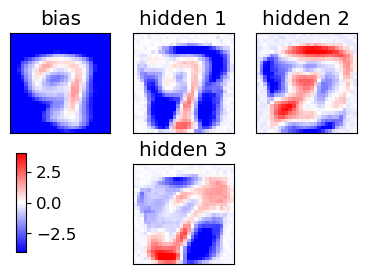

Epoch 101, Log-Likelihood: -163.1881369037599
epoch 101 / 150  Nt: 6  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 6  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 6  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 6  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 6  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -162.3886345826458
epoch 106 / 150  Nt: 6  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 6  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 6  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 6  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 6  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -164.682798

<Figure size 640x480 with 0 Axes>

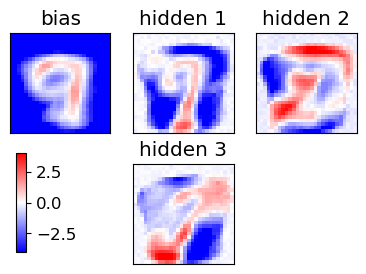

Epoch 121, Log-Likelihood: -164.18272632740448
epoch 121 / 150  Nt: 6  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 6  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 6  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 6  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 6  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -164.8498563549749
epoch 126 / 150  Nt: 6  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 6  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 6  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 6  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 6  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -163.37006

<Figure size 640x480 with 0 Axes>

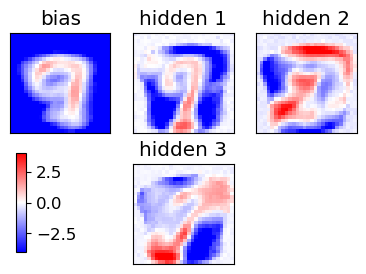

Epoch 141, Log-Likelihood: -163.05345036895525
epoch 141 / 150  Nt: 6  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 6  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 6  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 6  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 6  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -163.72421960342626
epoch 146 / 150  Nt: 6  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 6  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 6  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 6  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 6  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

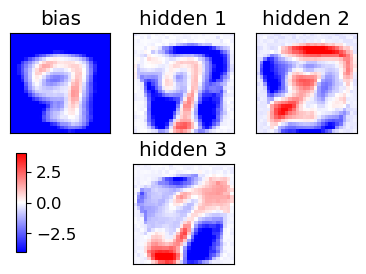

Epoch 151, Log-Likelihood: -162.85848548893082


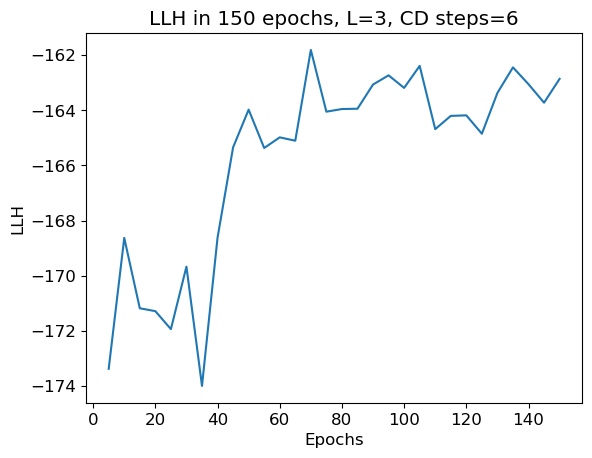

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

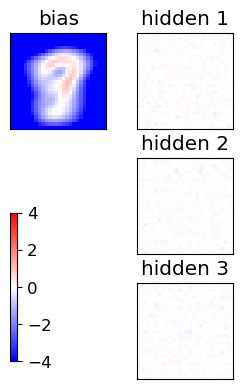

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[21048  9120  3422 15592 17598 16237  3113 13705 19499   422]
[ 5909 20992 20638 15952  4768 14327 12199 18987 14994  2430]
[   42 10691  8806  1419 16818 16607 13512  5915 15094  8647]
epoch 1 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -165.88552150786705
epoch 6 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 8  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 8  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

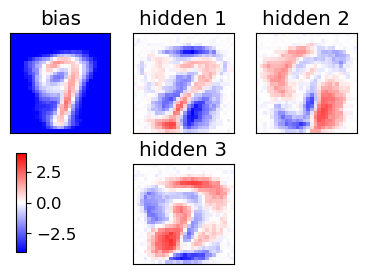

Epoch 21, Log-Likelihood: -164.1497682008181
epoch 21 / 150  Nt: 8  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 8  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 8  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 8  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 8  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -164.14636484741058
epoch 26 / 150  Nt: 8  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 8  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 8  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 8  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 8  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -166.36870798971682
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

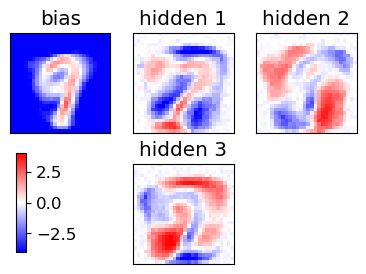

Epoch 41, Log-Likelihood: -165.81327101389533
epoch 41 / 150  Nt: 8  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 8  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 8  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 8  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 8  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -164.6414243938295
epoch 46 / 150  Nt: 8  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 8  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 8  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 8  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 8  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -164.0862899407327
epoch 51 / 150

<Figure size 640x480 with 0 Axes>

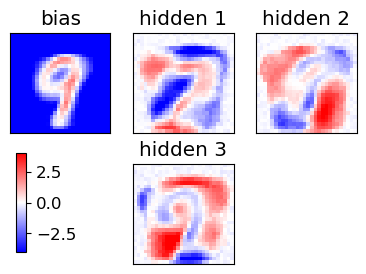

Epoch 61, Log-Likelihood: -161.6898785300036
epoch 61 / 150  Nt: 8  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 8  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 8  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 8  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 8  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -161.82121133764733
epoch 66 / 150  Nt: 8  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 8  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 8  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 8  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 8  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -163.15756400459117
epoch 7

<Figure size 640x480 with 0 Axes>

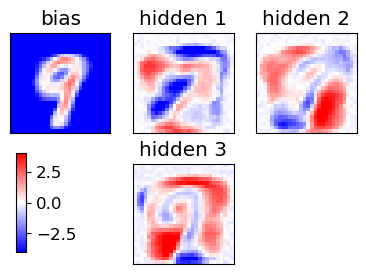

Epoch 81, Log-Likelihood: -160.88792786820474
epoch 81 / 150  Nt: 8  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 8  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 8  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 8  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 8  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -160.69985776721794
epoch 86 / 150  Nt: 8  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 8  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 8  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 8  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 8  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -160.9657580032082
epo

<Figure size 640x480 with 0 Axes>

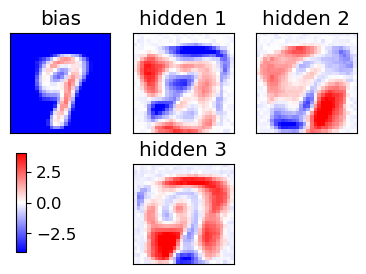

Epoch 101, Log-Likelihood: -161.85603541751502
epoch 101 / 150  Nt: 8  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 8  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 8  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 8  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 8  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -162.5312962266324
epoch 106 / 150  Nt: 8  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 8  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 8  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 8  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 8  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -162.13046

<Figure size 640x480 with 0 Axes>

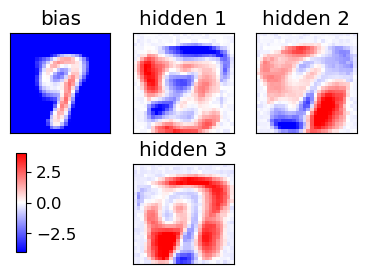

Epoch 121, Log-Likelihood: -160.43344581885884
epoch 121 / 150  Nt: 8  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 8  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 8  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 8  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 8  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -160.3652386060734
epoch 126 / 150  Nt: 8  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 8  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 8  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 8  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 8  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -161.96714

<Figure size 640x480 with 0 Axes>

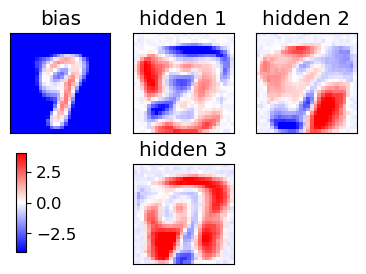

Epoch 141, Log-Likelihood: -160.59455538794685
epoch 141 / 150  Nt: 8  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 8  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 8  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 8  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 8  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -160.55065191267343
epoch 146 / 150  Nt: 8  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 8  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 8  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 8  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 8  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

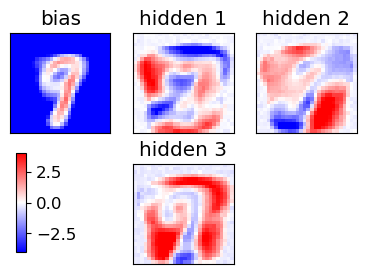

Epoch 151, Log-Likelihood: -160.36386410080522


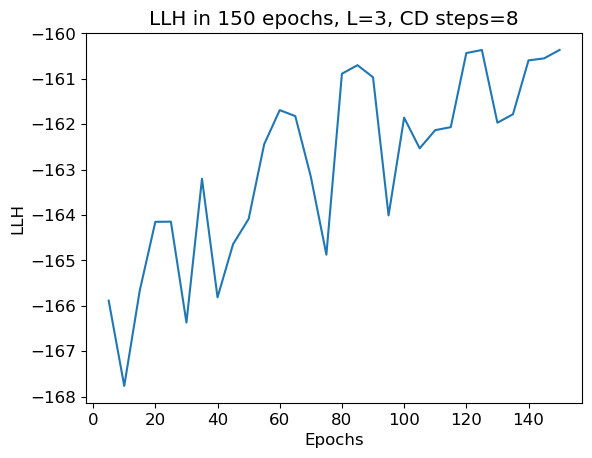

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

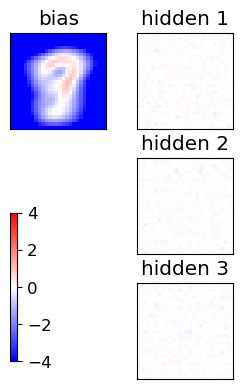

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[10865  2066  9444  1734 11208  4995  8032  4362  5935  7494]
[11424  7183 20302 12386  3240 20596  7724  2868  5380   594]
[13897 17529  7388  8843 14279  7849  8155  5209 18805 10709]
epoch 1 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -169.77630102012185
epoch 6 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 10  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 10  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch

<Figure size 640x480 with 0 Axes>

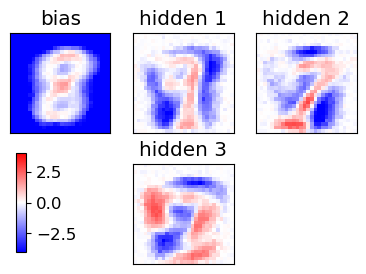

Epoch 21, Log-Likelihood: -164.20800672327414
epoch 21 / 150  Nt: 10  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 10  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 10  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 10  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 10  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -163.83224612862026
epoch 26 / 150  Nt: 10  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 10  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 10  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 10  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 10  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -163.3265259107577
epo

<Figure size 640x480 with 0 Axes>

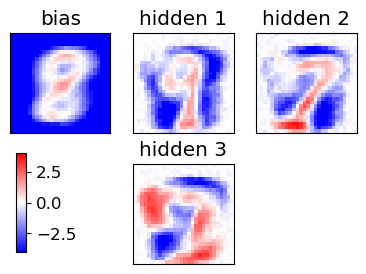

Epoch 41, Log-Likelihood: -160.5204107928425
epoch 41 / 150  Nt: 10  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 10  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 10  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 10  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 10  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -161.16742533737948
epoch 46 / 150  Nt: 10  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 10  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 10  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 10  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 10  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -164.39875718809313
epo

<Figure size 640x480 with 0 Axes>

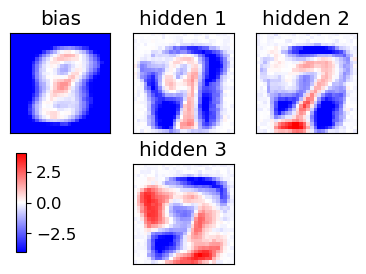

Epoch 61, Log-Likelihood: -162.2223198920745
epoch 61 / 150  Nt: 10  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 10  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 10  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 10  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 10  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -163.18696648658297
epoch 66 / 150  Nt: 10  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 10  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 10  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 10  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 10  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -163.842387576748

<Figure size 640x480 with 0 Axes>

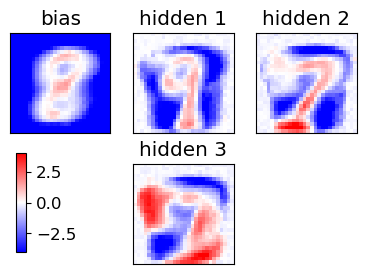

Epoch 81, Log-Likelihood: -163.51140004703464
epoch 81 / 150  Nt: 10  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 10  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 10  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 10  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 10  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -161.7729171172915
epoch 86 / 150  Nt: 10  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 10  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 10  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 10  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 10  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -164.08198565

<Figure size 640x480 with 0 Axes>

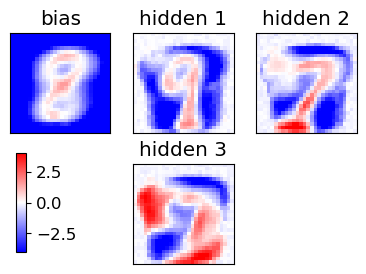

Epoch 101, Log-Likelihood: -162.01709272360466
epoch 101 / 150  Nt: 10  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 10  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 10  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 10  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 10  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -163.1379143060819
epoch 106 / 150  Nt: 10  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 10  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 10  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 10  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 10  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: 

<Figure size 640x480 with 0 Axes>

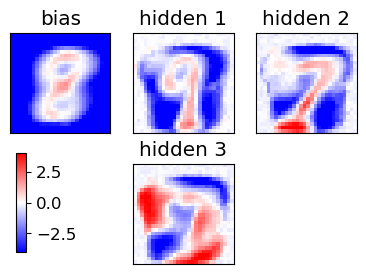

Epoch 121, Log-Likelihood: -163.212851099958
epoch 121 / 150  Nt: 10  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 10  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 10  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 10  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 10  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -161.1455784719639
epoch 126 / 150  Nt: 10  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 10  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 10  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 10  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 10  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -1

<Figure size 640x480 with 0 Axes>

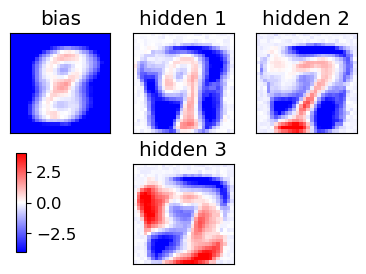

Epoch 141, Log-Likelihood: -161.59283352261932
epoch 141 / 150  Nt: 10  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 10  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 10  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 10  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 10  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -161.9004337514313
epoch 146 / 150  Nt: 10  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 10  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 10  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 10  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 10  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

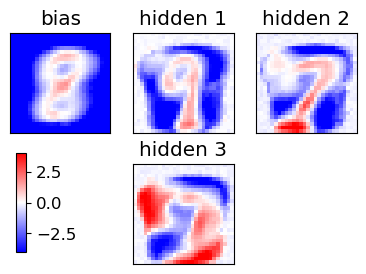

Epoch 151, Log-Likelihood: -162.84956992568192


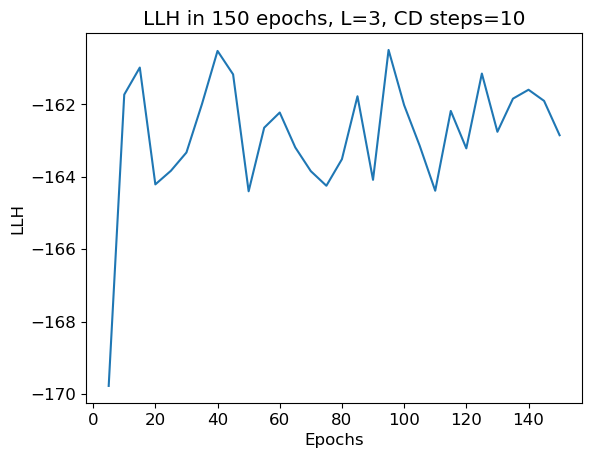

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

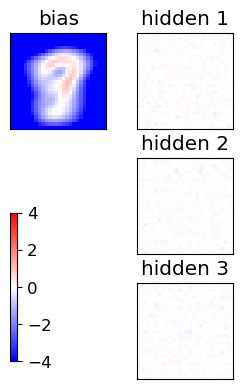

Starting the training
[  707   589  7429  5439  6369  6491  9823   782 13411 10565]
[16665 11076  2391 17292 16997   259 20023 16052  1297 14974]
[ 5729 10765   632  6784 19330  8700 16935 11977   476  2537]
[ 7625  2603 16176  9223   344 19898 16074 14877 19301 14407]
epoch 1 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -167.43194712108775
epoch 6 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 12  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 12  N: 11  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch

<Figure size 640x480 with 0 Axes>

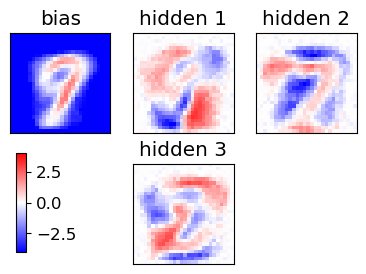

Epoch 21, Log-Likelihood: -167.41512699438212
epoch 21 / 150  Nt: 12  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 12  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 12  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 12  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 12  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -165.47928736846362
epoch 26 / 150  Nt: 12  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 12  N: 24  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 12  N: 26  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 12  N: 27  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 12  N: 28  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -167.3927872623059
epo

<Figure size 640x480 with 0 Axes>

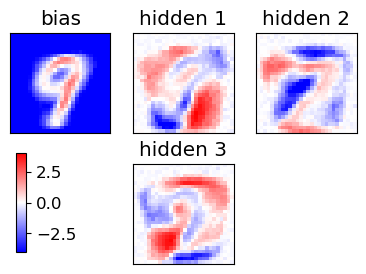

Epoch 41, Log-Likelihood: -162.99793576300314
epoch 41 / 150  Nt: 12  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 12  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 12  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 12  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 12  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -164.71612747226203
epoch 46 / 150  Nt: 12  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 12  N: 56  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 12  N: 58  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 12  N: 60  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 12  N: 62  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -164.14441872875048
ep

<Figure size 640x480 with 0 Axes>

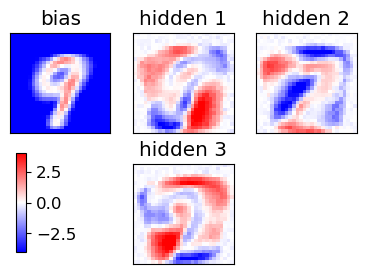

Epoch 61, Log-Likelihood: -163.4956957819272
epoch 61 / 150  Nt: 12  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 12  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 12  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 12  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 12  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -163.03848030744945
epoch 66 / 150  Nt: 12  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 12  N: 106  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 12  N: 109  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 12  N: 112  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 12  N: 115  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -160.678926722934

<Figure size 640x480 with 0 Axes>

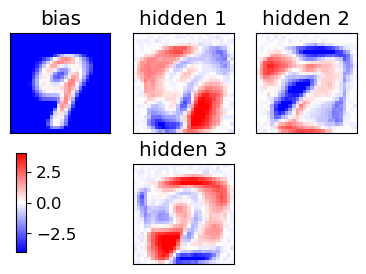

Epoch 81, Log-Likelihood: -163.11104436647992
epoch 81 / 150  Nt: 12  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 12  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 12  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 12  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 12  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -162.8483747389853
epoch 86 / 150  Nt: 12  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 12  N: 173  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 12  N: 177  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 12  N: 180  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 12  N: 184  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -164.06807206

<Figure size 640x480 with 0 Axes>

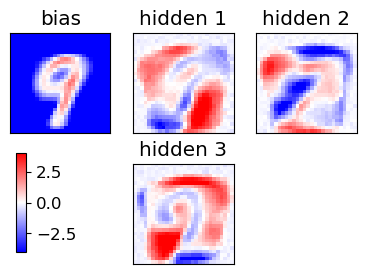

Epoch 101, Log-Likelihood: -160.27219046506985
epoch 101 / 150  Nt: 12  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 12  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 12  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 12  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 12  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -160.04551786167517
epoch 106 / 150  Nt: 12  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 12  N: 257  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 12  N: 262  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 12  N: 267  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 12  N: 272  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood:

<Figure size 640x480 with 0 Axes>

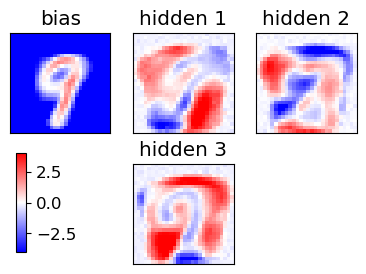

Epoch 121, Log-Likelihood: -161.64140939863478
epoch 121 / 150  Nt: 12  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 12  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 12  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 12  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 12  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -161.24891033474242
epoch 126 / 150  Nt: 12  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 12  N: 360  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 12  N: 365  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 12  N: 371  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 12  N: 377  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood:

<Figure size 640x480 with 0 Axes>

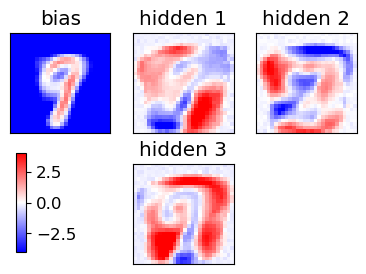

Epoch 141, Log-Likelihood: -160.5020892125921
epoch 141 / 150  Nt: 12  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 12  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 12  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 12  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 12  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -161.05009245910023
epoch 146 / 150  Nt: 12  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 12  N: 480  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 12  N: 486  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 12  N: 493  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 12  N: 500  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

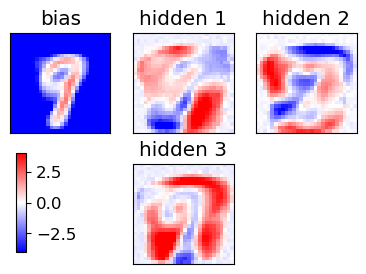

Epoch 151, Log-Likelihood: -160.54950479171248


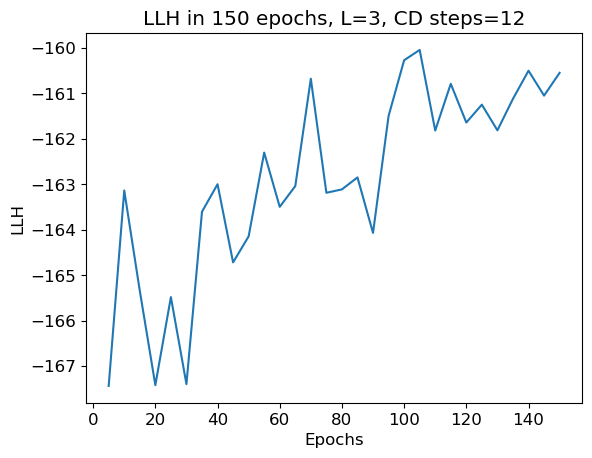

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

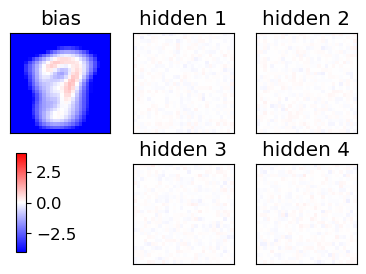

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[ 7052  9814  5579  7242 13312 15244 14674 13257  5327 13715]
[ 3498  7395  1888  3449  1287 10349  4586  2932 15766 19248]
[19864  8761 16678 16469 18948 10006 18422 20078  9691  4579]
epoch 1 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -166.7216455216658
epoch 6 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 2  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 2  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150 

<Figure size 640x480 with 0 Axes>

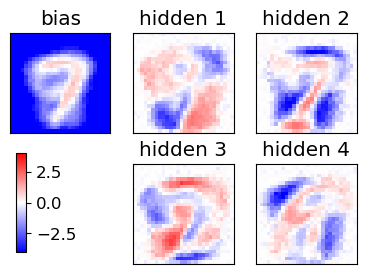

Epoch 21, Log-Likelihood: -162.97716688956928
epoch 21 / 150  Nt: 2  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 2  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 2  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 2  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 2  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -160.6916219724479
epoch 26 / 150  Nt: 2  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 2  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 2  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 2  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 2  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -162.20947164317224
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

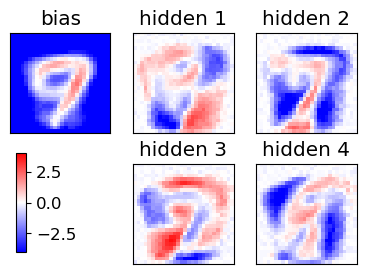

Epoch 41, Log-Likelihood: -162.44247849504325
epoch 41 / 150  Nt: 2  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 2  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 2  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 2  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 2  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -161.08147958945904
epoch 46 / 150  Nt: 2  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 2  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 2  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 2  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 2  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -162.8587789818319
epoch 51 / 15

<Figure size 640x480 with 0 Axes>

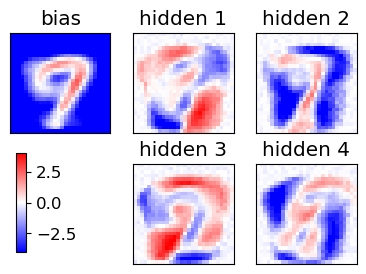

Epoch 61, Log-Likelihood: -158.64984071292182
epoch 61 / 150  Nt: 2  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 2  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 2  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 2  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 2  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -159.24377948478303
epoch 66 / 150  Nt: 2  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 2  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 2  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 2  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 2  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -159.92069240443436
epoch 

<Figure size 640x480 with 0 Axes>

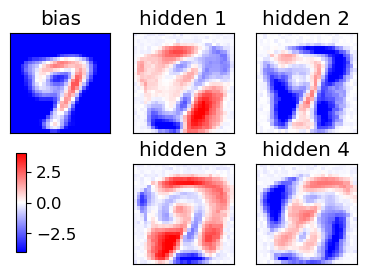

Epoch 81, Log-Likelihood: -158.47249185983532
epoch 81 / 150  Nt: 2  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 2  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 2  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 2  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 2  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -158.0399443451035
epoch 86 / 150  Nt: 2  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 2  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 2  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 2  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 2  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -160.34884332283846
epo

<Figure size 640x480 with 0 Axes>

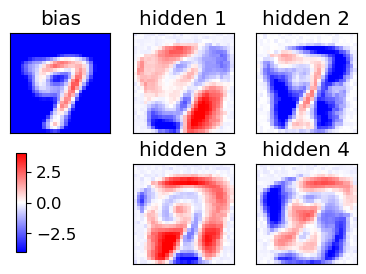

Epoch 101, Log-Likelihood: -158.89511988562498
epoch 101 / 150  Nt: 2  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 2  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 2  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 2  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 2  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -158.1372045227712
epoch 106 / 150  Nt: 2  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 2  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 2  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 2  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 2  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -158.52874

<Figure size 640x480 with 0 Axes>

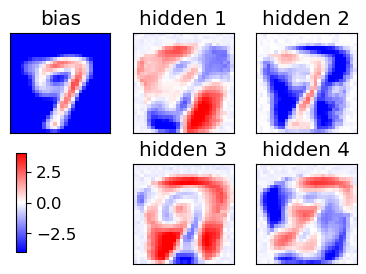

Epoch 121, Log-Likelihood: -157.63996385063282
epoch 121 / 150  Nt: 2  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 2  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 2  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 2  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 2  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -158.03275005956266
epoch 126 / 150  Nt: 2  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 2  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 2  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 2  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 2  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -158.5519

<Figure size 640x480 with 0 Axes>

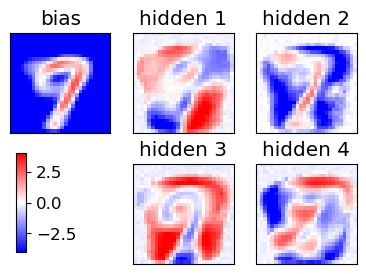

Epoch 141, Log-Likelihood: -157.55888854343812
epoch 141 / 150  Nt: 2  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 2  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 2  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 2  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 2  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -157.6027738670637
epoch 146 / 150  Nt: 2  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 2  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 2  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 2  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 2  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

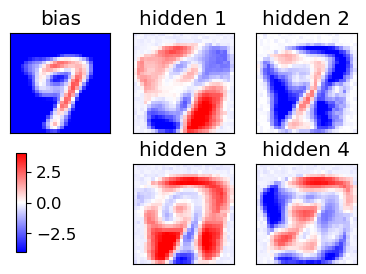

Epoch 151, Log-Likelihood: -157.15626863646474


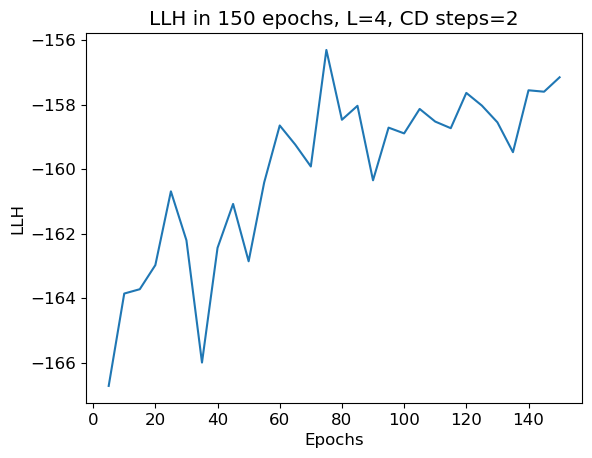

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

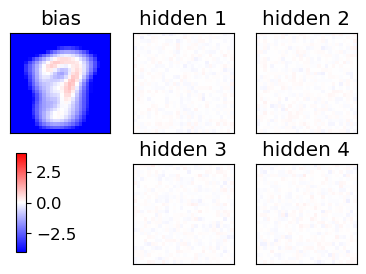

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[ 1006 19100 19451 16479  1412 12862 19664 12053 12114 11423]
[12956 18310 11494 13538 13519 16338  7784 13531 16801  8990]
[ 2723  6546 13042  5931 13968 19337 18060  2164  1448  8030]
epoch 1 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -174.89660594890324
epoch 6 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 4  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 4  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

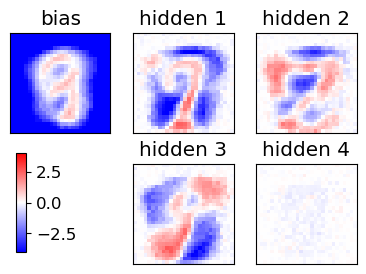

Epoch 21, Log-Likelihood: -164.27524299341366
epoch 21 / 150  Nt: 4  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 4  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 4  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 4  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 4  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -165.8156349851701
epoch 26 / 150  Nt: 4  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 4  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 4  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 4  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 4  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -164.4475741534032
epoch 31 / 150

<Figure size 640x480 with 0 Axes>

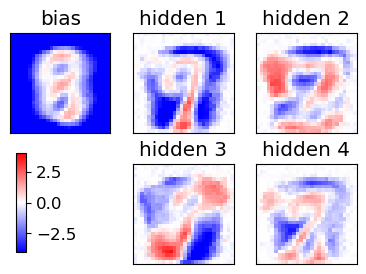

Epoch 41, Log-Likelihood: -160.82760694801362
epoch 41 / 150  Nt: 4  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 4  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 4  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 4  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 4  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -159.38475289459865
epoch 46 / 150  Nt: 4  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 4  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 4  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 4  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 4  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -159.35310576107062
epoch 51 / 1

<Figure size 640x480 with 0 Axes>

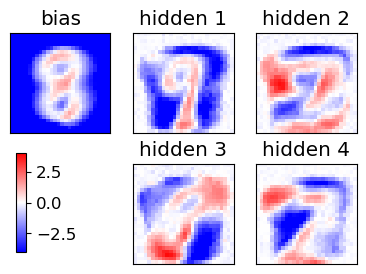

Epoch 61, Log-Likelihood: -161.39580124338516
epoch 61 / 150  Nt: 4  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 4  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 4  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 4  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 4  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -163.4904187383278
epoch 66 / 150  Nt: 4  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 4  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 4  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 4  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 4  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -159.3889106100245
epoch 71

<Figure size 640x480 with 0 Axes>

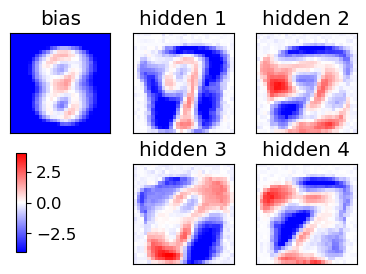

Epoch 81, Log-Likelihood: -161.41685822272726
epoch 81 / 150  Nt: 4  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 4  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 4  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 4  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 4  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -162.0379528567613
epoch 86 / 150  Nt: 4  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 4  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 4  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 4  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 4  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -163.24493874860352
epo

<Figure size 640x480 with 0 Axes>

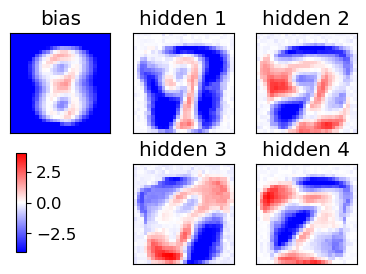

Epoch 101, Log-Likelihood: -162.36425211106675
epoch 101 / 150  Nt: 4  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 4  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 4  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 4  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 4  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -159.41489392067618
epoch 106 / 150  Nt: 4  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 4  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 4  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 4  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 4  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -160.6141

<Figure size 640x480 with 0 Axes>

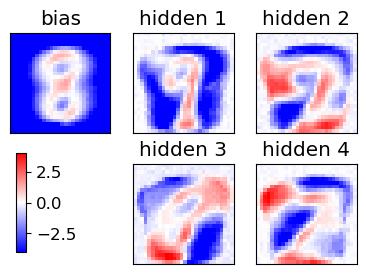

Epoch 121, Log-Likelihood: -160.05158027360181
epoch 121 / 150  Nt: 4  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 4  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 4  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 4  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 4  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -160.62979686734963
epoch 126 / 150  Nt: 4  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 4  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 4  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 4  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 4  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -159.7803

<Figure size 640x480 with 0 Axes>

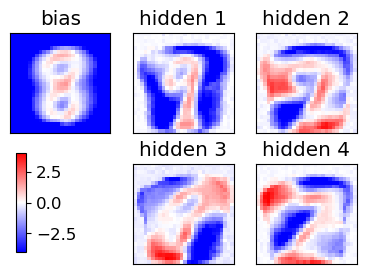

Epoch 141, Log-Likelihood: -160.54848177846958
epoch 141 / 150  Nt: 4  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 4  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 4  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 4  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 4  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -159.53508931622753
epoch 146 / 150  Nt: 4  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 4  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 4  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 4  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 4  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

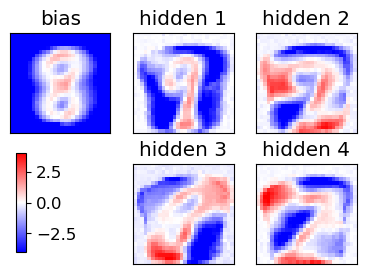

Epoch 151, Log-Likelihood: -159.58853713083545


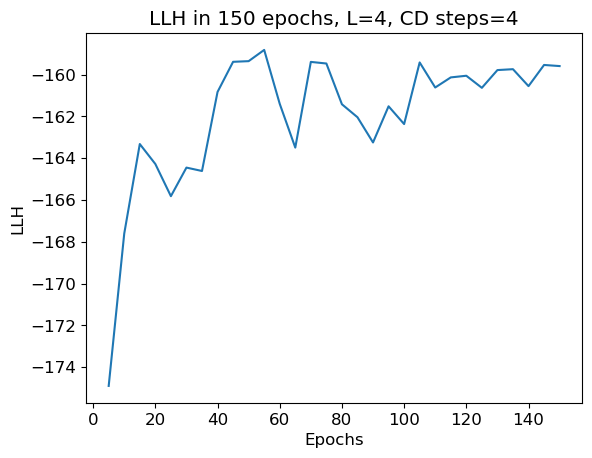

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

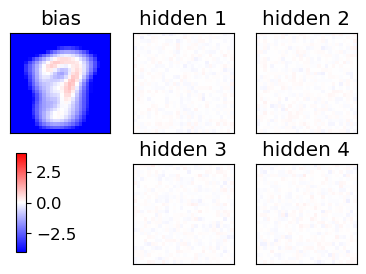

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[ 6961 13511  2852 13881  6314    96  8464  7785  1571 15216]
[ 6534 13064 19963 19651  4086  3581 11802 19847  7580  1576]
[18061 11422  4134 10297  5380  8134 12372 10070  6197 20233]
epoch 1 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -166.0242785002123
epoch 6 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 6  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 6  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150 

<Figure size 640x480 with 0 Axes>

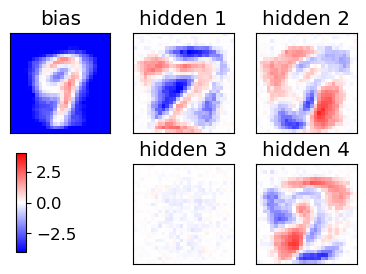

Epoch 21, Log-Likelihood: -160.7431893362148
epoch 21 / 150  Nt: 6  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 6  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 6  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 6  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 6  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -163.72427506023917
epoch 26 / 150  Nt: 6  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 6  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 6  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 6  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 6  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -162.6324003611442
epoch 31 / 150

<Figure size 640x480 with 0 Axes>

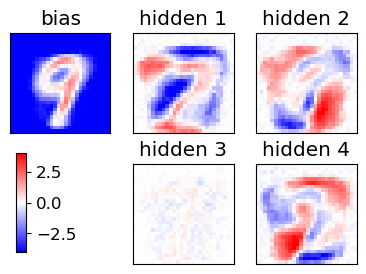

Epoch 41, Log-Likelihood: -163.9878637449003
epoch 41 / 150  Nt: 6  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 6  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 6  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 6  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 6  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -161.48454063788876
epoch 46 / 150  Nt: 6  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 6  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 6  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 6  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 6  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -161.50332193223
epoch 51 / 150  

<Figure size 640x480 with 0 Axes>

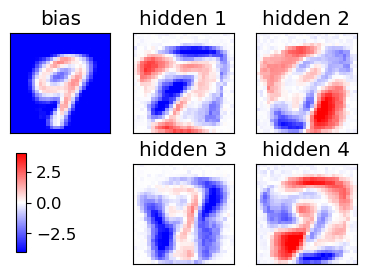

Epoch 61, Log-Likelihood: -159.81311229937998
epoch 61 / 150  Nt: 6  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 6  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 6  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 6  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 6  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -159.188043842588
epoch 66 / 150  Nt: 6  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 6  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 6  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 6  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 6  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -157.82988873103594
epoch 71

<Figure size 640x480 with 0 Axes>

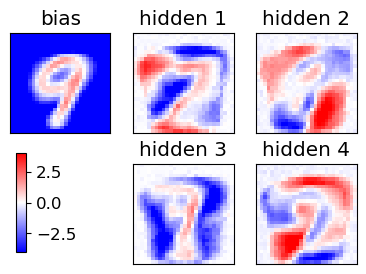

Epoch 81, Log-Likelihood: -156.77533518005467
epoch 81 / 150  Nt: 6  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 6  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 6  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 6  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 6  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -155.91540596780433
epoch 86 / 150  Nt: 6  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 6  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 6  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 6  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 6  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -158.75321599863105
ep

<Figure size 640x480 with 0 Axes>

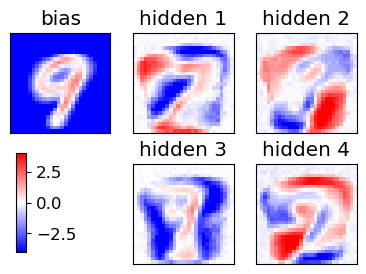

Epoch 101, Log-Likelihood: -157.60753237405933
epoch 101 / 150  Nt: 6  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 6  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 6  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 6  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 6  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -155.53280652612196
epoch 106 / 150  Nt: 6  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 6  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 6  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 6  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 6  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -157.0038

<Figure size 640x480 with 0 Axes>

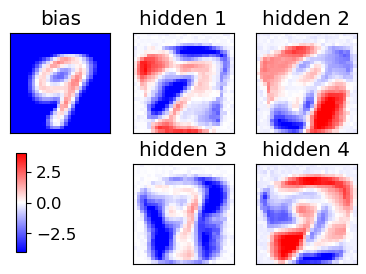

Epoch 121, Log-Likelihood: -157.31532537576385
epoch 121 / 150  Nt: 6  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 6  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 6  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 6  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 6  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -157.53193108748945
epoch 126 / 150  Nt: 6  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 6  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 6  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 6  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 6  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -157.5394

<Figure size 640x480 with 0 Axes>

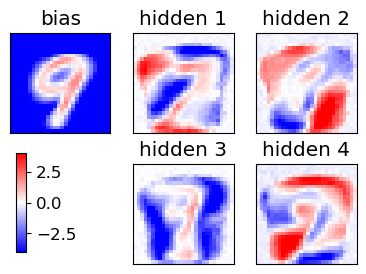

Epoch 141, Log-Likelihood: -156.14059044189054
epoch 141 / 150  Nt: 6  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 6  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 6  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 6  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 6  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -156.49553915478816
epoch 146 / 150  Nt: 6  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 6  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 6  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 6  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 6  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

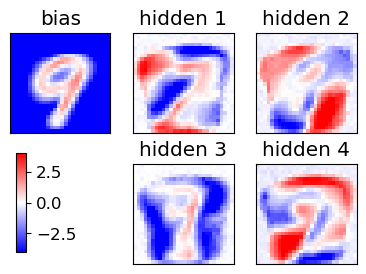

Epoch 151, Log-Likelihood: -155.19067375347


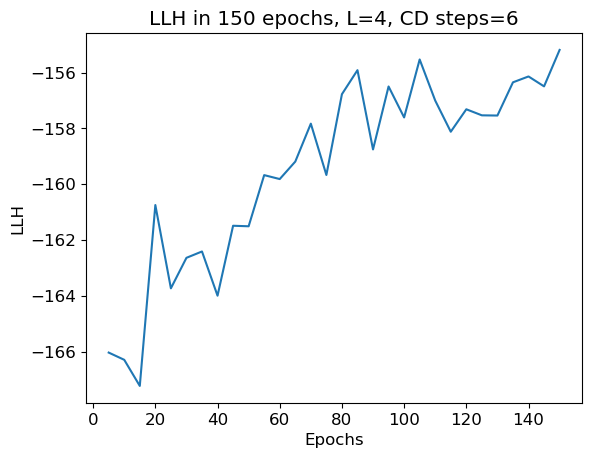

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

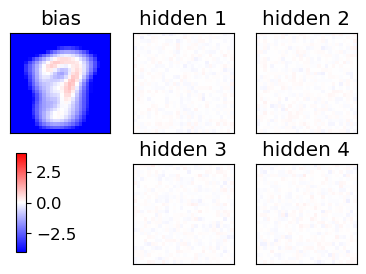

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[17280 10273  4254 16546  3174  8197 15045 11367 12720 15439]
[  708 10517 10786 20066  8803 21008  9237 20416  5510  5227]
[20783 17149  5876 17477 17752 14385  8160 15764  1339 19551]
epoch 1 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -165.05817798018435
epoch 6 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 8  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 8  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

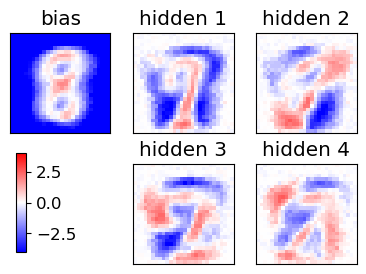

Epoch 21, Log-Likelihood: -161.27862283398827
epoch 21 / 150  Nt: 8  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 8  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 8  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 8  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 8  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -158.5974770325211
epoch 26 / 150  Nt: 8  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 8  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 8  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 8  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 8  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -160.0165481510181
epoch 31 / 150

<Figure size 640x480 with 0 Axes>

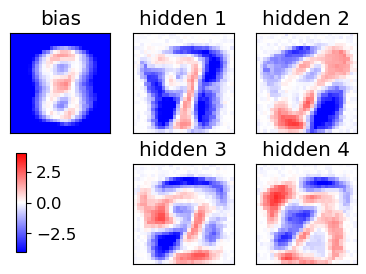

Epoch 41, Log-Likelihood: -157.09646945263987
epoch 41 / 150  Nt: 8  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 8  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 8  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 8  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 8  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -158.30564874582544
epoch 46 / 150  Nt: 8  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 8  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 8  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 8  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 8  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -157.879214928756
epoch 51 / 150

<Figure size 640x480 with 0 Axes>

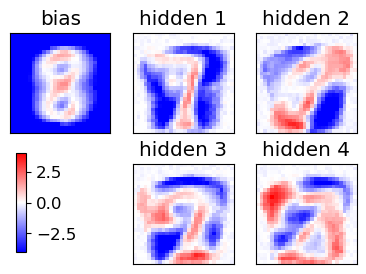

Epoch 61, Log-Likelihood: -160.0053911330584
epoch 61 / 150  Nt: 8  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 8  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 8  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 8  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 8  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -159.60791585139222
epoch 66 / 150  Nt: 8  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 8  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 8  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 8  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 8  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -159.77596463620452
epoch 7

<Figure size 640x480 with 0 Axes>

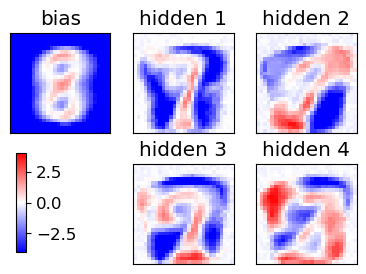

Epoch 81, Log-Likelihood: -158.9410349746649
epoch 81 / 150  Nt: 8  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 8  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 8  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 8  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 8  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -159.72243183005438
epoch 86 / 150  Nt: 8  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 8  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 8  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 8  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 8  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -159.0764490608928
epoc

<Figure size 640x480 with 0 Axes>

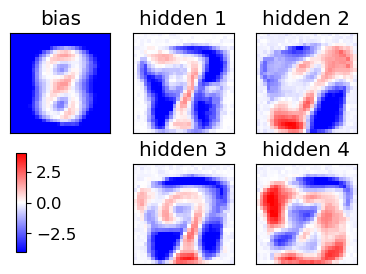

Epoch 101, Log-Likelihood: -159.79465718892914
epoch 101 / 150  Nt: 8  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 8  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 8  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 8  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 8  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -158.66706759823396
epoch 106 / 150  Nt: 8  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 8  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 8  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 8  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 8  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -160.0314

<Figure size 640x480 with 0 Axes>

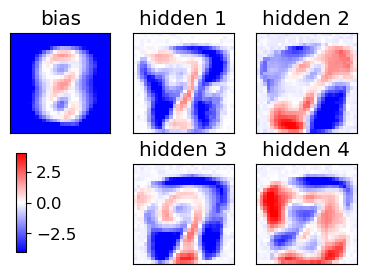

Epoch 121, Log-Likelihood: -157.84322416328027
epoch 121 / 150  Nt: 8  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 8  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 8  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 8  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 8  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -158.8446584382016
epoch 126 / 150  Nt: 8  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 8  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 8  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 8  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 8  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -159.10614

<Figure size 640x480 with 0 Axes>

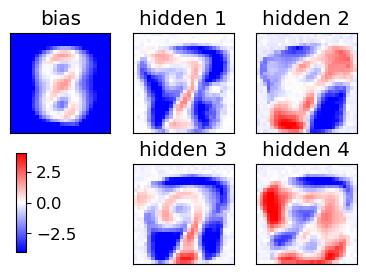

Epoch 141, Log-Likelihood: -157.60293222988335
epoch 141 / 150  Nt: 8  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 8  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 8  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 8  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 8  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -158.62315511756893
epoch 146 / 150  Nt: 8  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 8  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 8  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 8  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 8  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

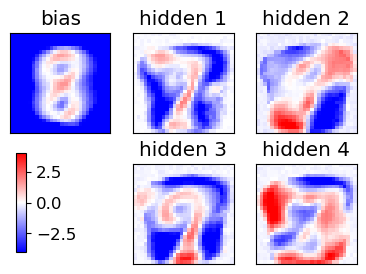

Epoch 151, Log-Likelihood: -158.36538186718872


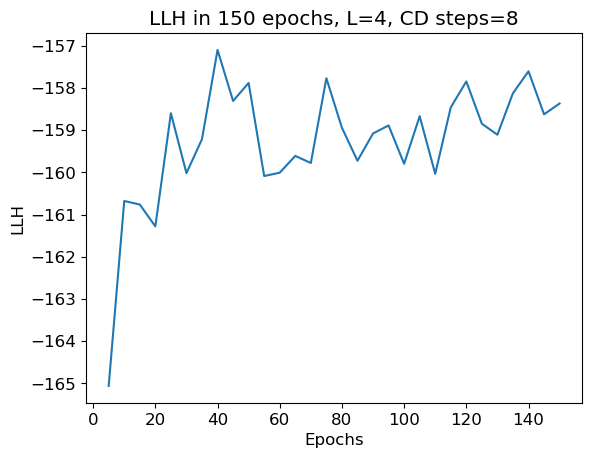

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

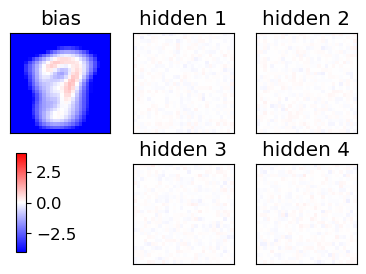

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[13918  8001  6424  5935  7575  9971   769 17361 20550 13625]
[ 3925  8713 11476 13512 16634   363 16587 19183 13744 15523]
[ 4741 11512  3707 20701 19465  8503 18908  2669 20698  6435]
epoch 1 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -167.8177894536656
epoch 6 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 10  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 10  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 

<Figure size 640x480 with 0 Axes>

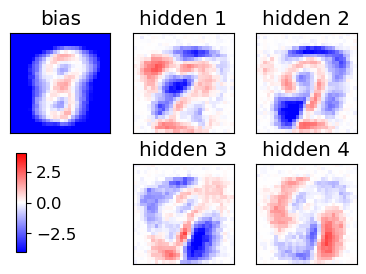

Epoch 21, Log-Likelihood: -159.66760418069356
epoch 21 / 150  Nt: 10  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 10  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 10  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 10  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 10  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -163.46196089244194
epoch 26 / 150  Nt: 10  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 10  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 10  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 10  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 10  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -160.21169950054943
ep

<Figure size 640x480 with 0 Axes>

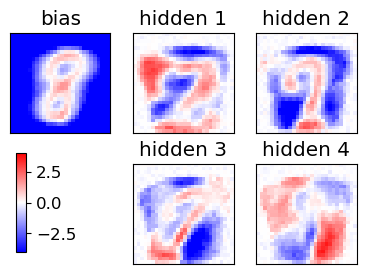

Epoch 41, Log-Likelihood: -156.96353818577268
epoch 41 / 150  Nt: 10  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 10  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 10  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 10  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 10  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -157.66314085591543
epoch 46 / 150  Nt: 10  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 10  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 10  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 10  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 10  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -160.42324869017543
ep

<Figure size 640x480 with 0 Axes>

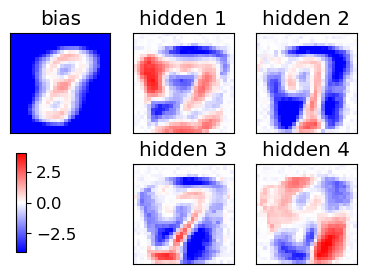

Epoch 61, Log-Likelihood: -160.40598262309965
epoch 61 / 150  Nt: 10  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 10  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 10  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 10  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 10  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -158.89592545072847
epoch 66 / 150  Nt: 10  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 10  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 10  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 10  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 10  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -160.07988415714

<Figure size 640x480 with 0 Axes>

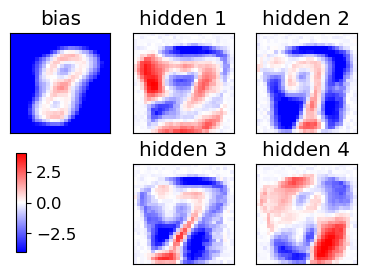

Epoch 81, Log-Likelihood: -161.90809625357824
epoch 81 / 150  Nt: 10  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 10  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 10  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 10  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 10  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -160.38317480898922
epoch 86 / 150  Nt: 10  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 10  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 10  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 10  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 10  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -160.2744078

<Figure size 640x480 with 0 Axes>

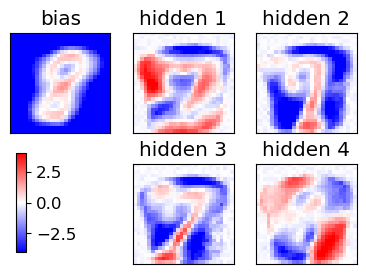

Epoch 101, Log-Likelihood: -160.72896663575773
epoch 101 / 150  Nt: 10  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 10  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 10  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 10  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 10  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -159.96228921175714
epoch 106 / 150  Nt: 10  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 10  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 10  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 10  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 10  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood:

<Figure size 640x480 with 0 Axes>

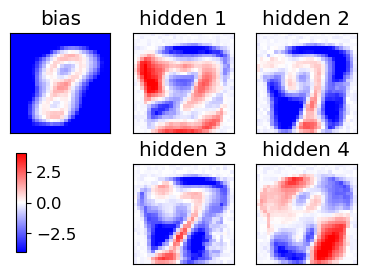

Epoch 121, Log-Likelihood: -163.1920025439827
epoch 121 / 150  Nt: 10  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 10  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 10  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 10  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 10  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -162.03088052348147
epoch 126 / 150  Nt: 10  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 10  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 10  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 10  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 10  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: 

<Figure size 640x480 with 0 Axes>

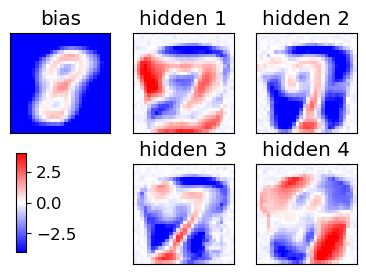

Epoch 141, Log-Likelihood: -160.51002765089572
epoch 141 / 150  Nt: 10  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 10  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 10  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 10  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 10  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -160.8888212588474
epoch 146 / 150  Nt: 10  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 10  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 10  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 10  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 10  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

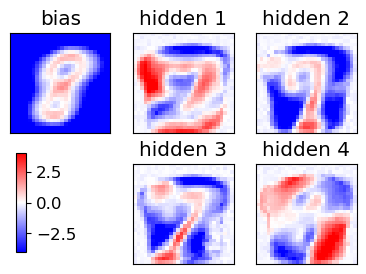

Epoch 151, Log-Likelihood: -160.9228394722526


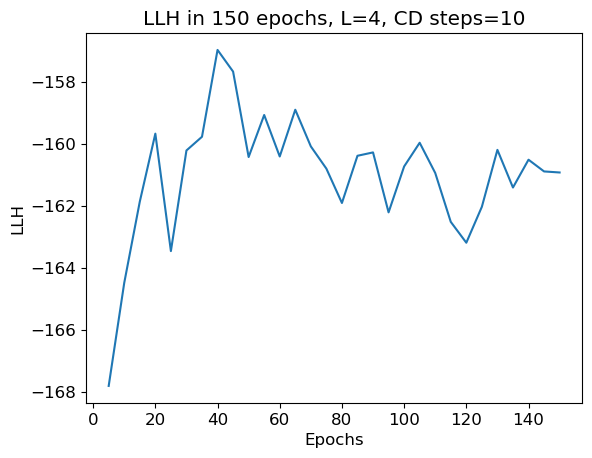

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

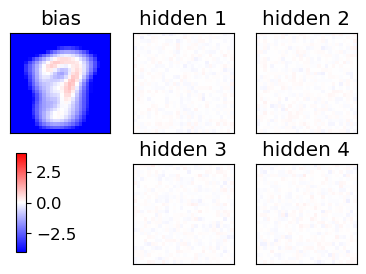

Starting the training
[ 3367  2976 14427    97 14896 14867 14004 18734 19184 20701]
[ 9732  1417 13724  4917  7905  4964  4055 10522  7790  2998]
[  789  2325  7151 13137  2967 12388 15480  1731  8607 13541]
[ 7948 14027  8933  3906 19050  2437 13141 19313 17092  9848]
epoch 1 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -167.62439534372842
epoch 6 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 12  N: 10  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 12  N: 11  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch

<Figure size 640x480 with 0 Axes>

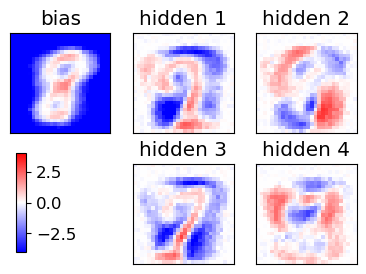

Epoch 21, Log-Likelihood: -158.6054085913859
epoch 21 / 150  Nt: 12  N: 18  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 12  N: 19  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 12  N: 20  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 12  N: 21  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 12  N: 22  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -161.88640538351652
epoch 26 / 150  Nt: 12  N: 23  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 12  N: 24  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 12  N: 26  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 12  N: 27  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 12  N: 28  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -163.93252693823644
epo

<Figure size 640x480 with 0 Axes>

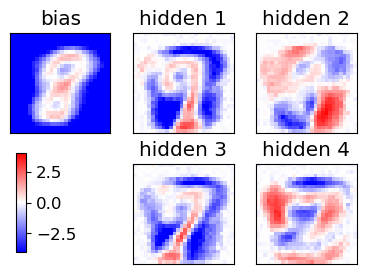

Epoch 41, Log-Likelihood: -163.62952136765858
epoch 41 / 150  Nt: 12  N: 45  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 12  N: 47  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 12  N: 48  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 12  N: 50  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 12  N: 52  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -160.7383370472353
epoch 46 / 150  Nt: 12  N: 54  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 12  N: 56  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 12  N: 58  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 12  N: 60  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 12  N: 62  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -162.3309440808321
epoc

<Figure size 640x480 with 0 Axes>

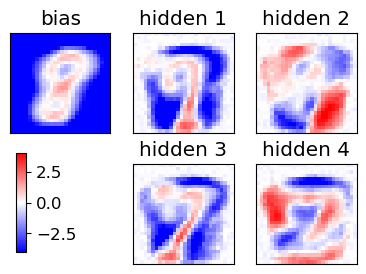

Epoch 61, Log-Likelihood: -164.354530455343
epoch 61 / 150  Nt: 12  N: 89  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 12  N: 92  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 12  N: 94  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 12  N: 97  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 12  N: 100  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -164.14306244462492
epoch 66 / 150  Nt: 12  N: 103  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 12  N: 106  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 12  N: 109  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 12  N: 112  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 12  N: 115  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -162.6562458532145

<Figure size 640x480 with 0 Axes>

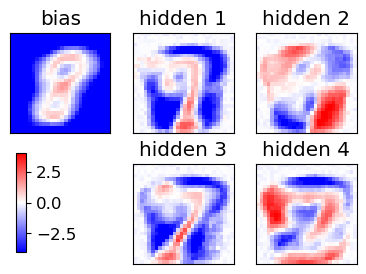

Epoch 81, Log-Likelihood: -161.64129830941764
epoch 81 / 150  Nt: 12  N: 151  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 12  N: 154  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 12  N: 158  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 12  N: 162  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 12  N: 165  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -161.063640898939
epoch 86 / 150  Nt: 12  N: 169  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 12  N: 173  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 12  N: 177  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 12  N: 180  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 12  N: 184  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -160.806964853

<Figure size 640x480 with 0 Axes>

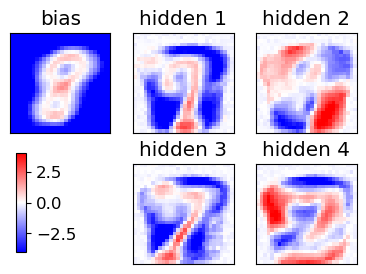

Epoch 101, Log-Likelihood: -161.4367471033195
epoch 101 / 150  Nt: 12  N: 230  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 12  N: 235  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 12  N: 239  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 12  N: 244  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 12  N: 248  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -161.4323713577338
epoch 106 / 150  Nt: 12  N: 253  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 12  N: 257  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 12  N: 262  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 12  N: 267  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 12  N: 272  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -

<Figure size 640x480 with 0 Axes>

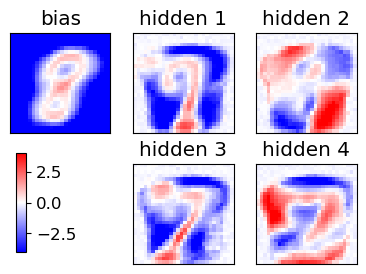

Epoch 121, Log-Likelihood: -162.46707292966587
epoch 121 / 150  Nt: 12  N: 327  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 12  N: 333  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 12  N: 338  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 12  N: 343  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 12  N: 349  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -161.3829360279151
epoch 126 / 150  Nt: 12  N: 354  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 12  N: 360  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 12  N: 365  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 12  N: 371  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 12  N: 377  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: 

<Figure size 640x480 with 0 Axes>

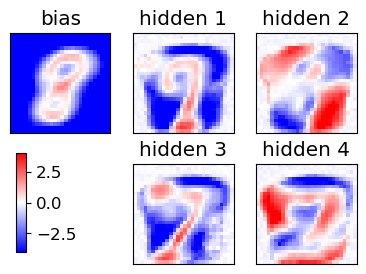

Epoch 141, Log-Likelihood: -161.94233282562618
epoch 141 / 150  Nt: 12  N: 442  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 12  N: 448  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 12  N: 455  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 12  N: 461  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 12  N: 467  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -160.68011988001862
epoch 146 / 150  Nt: 12  N: 474  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 12  N: 480  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 12  N: 486  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 12  N: 493  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 12  N: 500  L: 4  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

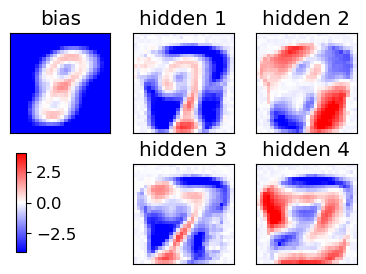

Epoch 151, Log-Likelihood: -159.33603291970175


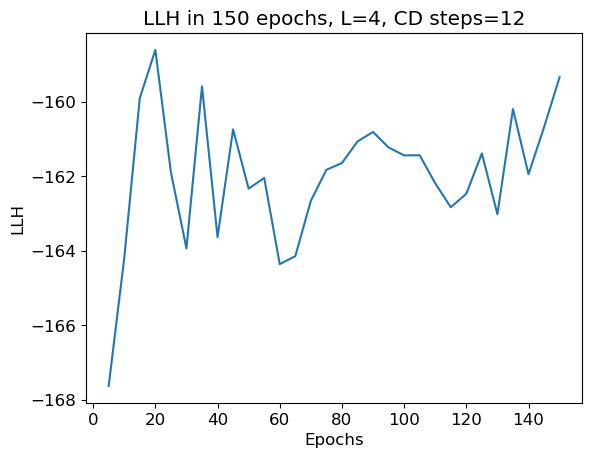

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

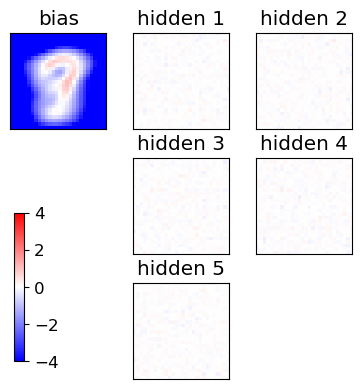

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[16046  8709  4141 18967 20413  7716  9424 11366 12952  2829]
[13830  9394  2518  4903  7622   126 14284  1309  9923  4286]
[19916 15120 15076 12898 18539 19284 10322  7509 10146  7642]
epoch 1 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -162.27690926069084
epoch 6 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 2  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 2  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

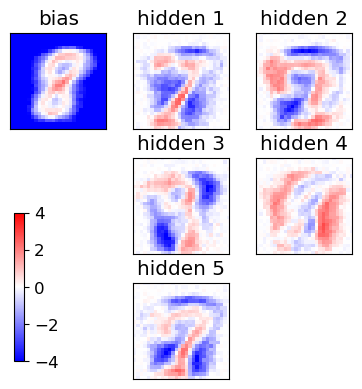

Epoch 21, Log-Likelihood: -162.7782817833111
epoch 21 / 150  Nt: 2  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 2  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 2  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 2  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 2  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -160.7400875844835
epoch 26 / 150  Nt: 2  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 2  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 2  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 2  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 2  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -162.36514833146347
epoch 31 / 150

<Figure size 640x480 with 0 Axes>

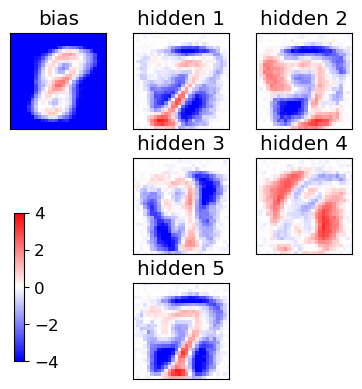

Epoch 41, Log-Likelihood: -163.43514914669993
epoch 41 / 150  Nt: 2  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 2  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 2  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 2  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 2  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -158.9462334951302
epoch 46 / 150  Nt: 2  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 2  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 2  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 2  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 2  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -159.44517081166796
epoch 51 / 15

<Figure size 640x480 with 0 Axes>

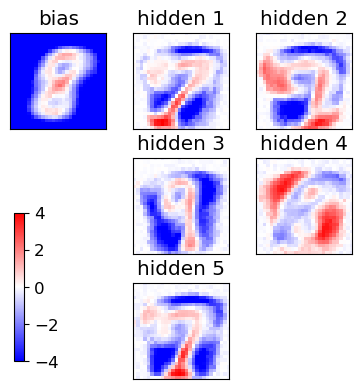

Epoch 61, Log-Likelihood: -158.16958603488047
epoch 61 / 150  Nt: 2  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 2  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 2  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 2  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 2  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -157.36977589924336
epoch 66 / 150  Nt: 2  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 2  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 2  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 2  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 2  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -158.93802976732158
epoch 

<Figure size 640x480 with 0 Axes>

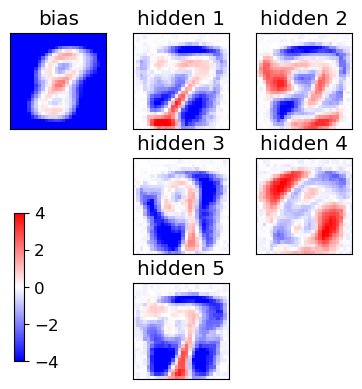

Epoch 81, Log-Likelihood: -155.27773637453643
epoch 81 / 150  Nt: 2  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 2  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 2  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 2  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 2  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -157.90197960062804
epoch 86 / 150  Nt: 2  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 2  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 2  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 2  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 2  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -159.79476486330157
ep

<Figure size 640x480 with 0 Axes>

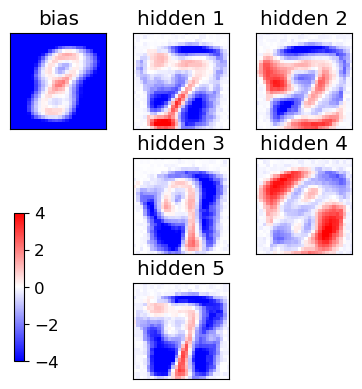

Epoch 101, Log-Likelihood: -158.12924005077616
epoch 101 / 150  Nt: 2  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 2  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 2  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 2  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 2  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -157.3470079643882
epoch 106 / 150  Nt: 2  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 2  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 2  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 2  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 2  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -160.47662

<Figure size 640x480 with 0 Axes>

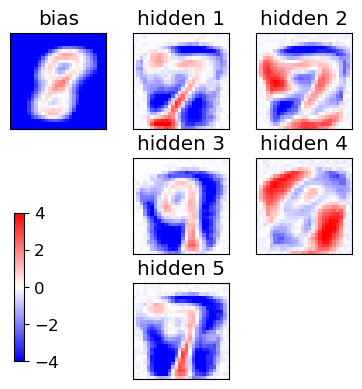

Epoch 121, Log-Likelihood: -160.8976211067567
epoch 121 / 150  Nt: 2  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 2  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 2  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 2  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 2  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -159.96715096000278
epoch 126 / 150  Nt: 2  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 2  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 2  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 2  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 2  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -160.75478

<Figure size 640x480 with 0 Axes>

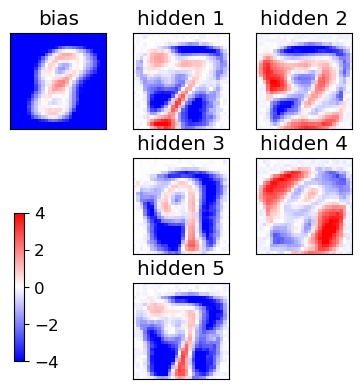

Epoch 141, Log-Likelihood: -158.28865932925234
epoch 141 / 150  Nt: 2  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 2  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 2  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 2  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 2  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -159.27807252228104
epoch 146 / 150  Nt: 2  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 2  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 2  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 2  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 2  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

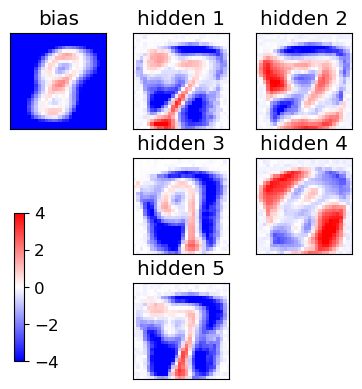

Epoch 151, Log-Likelihood: -160.63300129702867


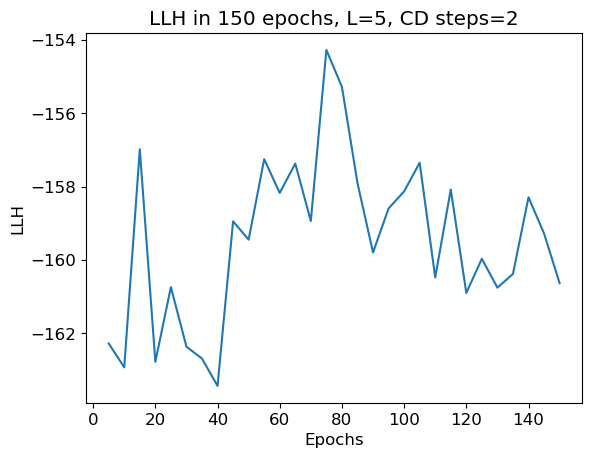

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

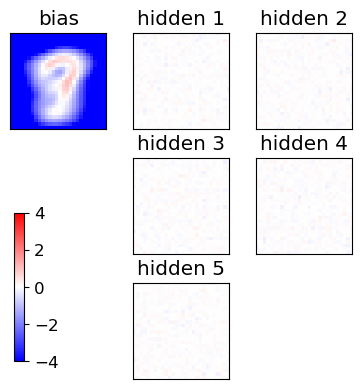

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[14500 18352  9718  3366 19969 18056  7856  8849 20207  7007]
[ 5936  7355  9615 13704 11890  9325 12962   346   637  3339]
[ 4996 19535 20324 19414 11292  2210 14020  9963  2891  1572]
epoch 1 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -166.39343995173343
epoch 6 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 4  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 4  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

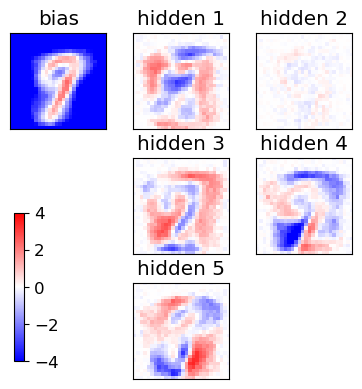

Epoch 21, Log-Likelihood: -162.18989883019483
epoch 21 / 150  Nt: 4  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 4  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 4  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 4  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 4  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -158.71118176806118
epoch 26 / 150  Nt: 4  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 4  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 4  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 4  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 4  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -156.06566755239268
epoch 31 / 1

<Figure size 640x480 with 0 Axes>

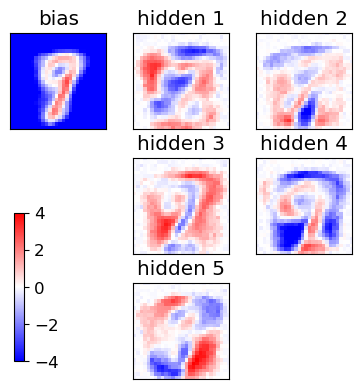

Epoch 41, Log-Likelihood: -155.01348394856956
epoch 41 / 150  Nt: 4  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 4  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 4  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 4  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 4  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -155.07029325859625
epoch 46 / 150  Nt: 4  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 4  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 4  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 4  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 4  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -154.17718850262122
epoch 51 / 1

<Figure size 640x480 with 0 Axes>

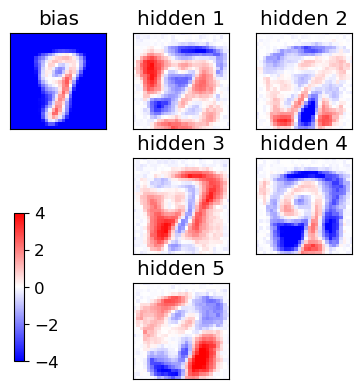

Epoch 61, Log-Likelihood: -155.18662125798008
epoch 61 / 150  Nt: 4  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 4  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 4  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 4  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 4  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -156.94953399134647
epoch 66 / 150  Nt: 4  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 4  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 4  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 4  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 4  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -155.73467838813835
epoch 

<Figure size 640x480 with 0 Axes>

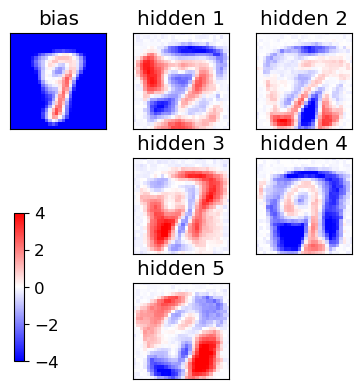

Epoch 81, Log-Likelihood: -157.564445412168
epoch 81 / 150  Nt: 4  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 4  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 4  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 4  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 4  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -155.328813101836
epoch 86 / 150  Nt: 4  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 4  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 4  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 4  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 4  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -154.9731579938429
epoch 9

<Figure size 640x480 with 0 Axes>

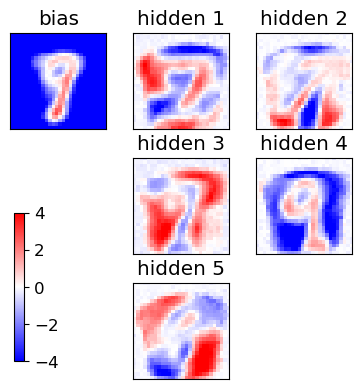

Epoch 101, Log-Likelihood: -157.0467959802732
epoch 101 / 150  Nt: 4  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 4  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 4  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 4  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 4  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -155.83650259503324
epoch 106 / 150  Nt: 4  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 4  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 4  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 4  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 4  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -158.16915

<Figure size 640x480 with 0 Axes>

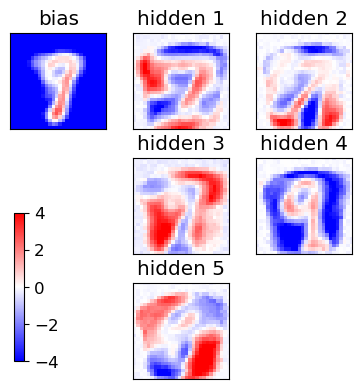

Epoch 121, Log-Likelihood: -155.5713476822846
epoch 121 / 150  Nt: 4  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 4  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 4  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 4  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 4  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -156.2490805317966
epoch 126 / 150  Nt: 4  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 4  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 4  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 4  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 4  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -156.179878

<Figure size 640x480 with 0 Axes>

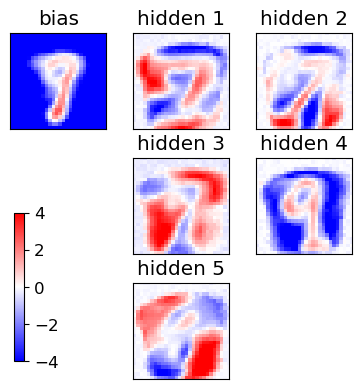

Epoch 141, Log-Likelihood: -156.51369228257036
epoch 141 / 150  Nt: 4  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 4  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 4  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 4  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 4  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -156.34626961418888
epoch 146 / 150  Nt: 4  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 4  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 4  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 4  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 4  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

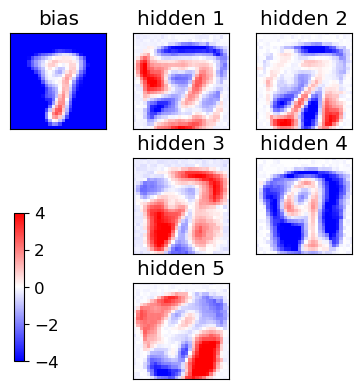

Epoch 151, Log-Likelihood: -156.25472948522287


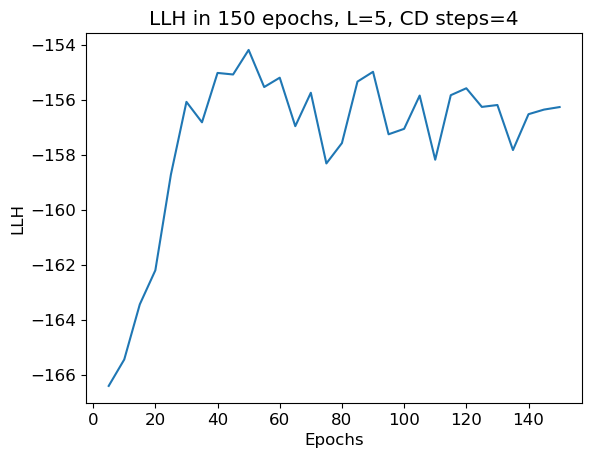

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

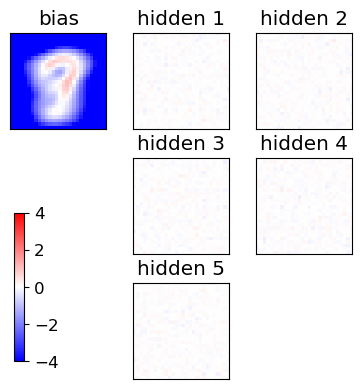

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[10355 18936  4163 14490  2079   847  8441  2654 20267  6677]
[ 4061  4161 14851  2290  3672 12174 20046  6063  4503  1635]
[15222 13720  2233  4944 17073 12116  3242 12693 20322 14943]
epoch 1 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -166.91714280397875
epoch 6 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 6  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 6  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

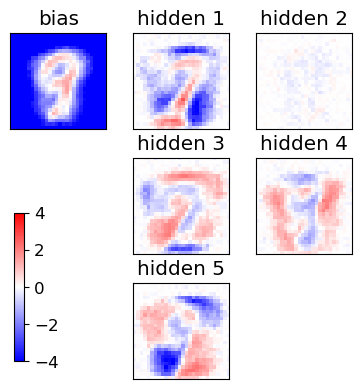

Epoch 21, Log-Likelihood: -163.46862439796206
epoch 21 / 150  Nt: 6  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 6  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 6  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 6  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 6  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -162.16297729675625
epoch 26 / 150  Nt: 6  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 6  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 6  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 6  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 6  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -163.0230826185697
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

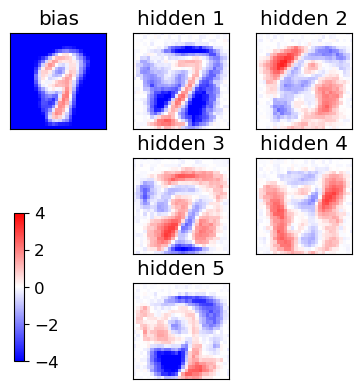

Epoch 41, Log-Likelihood: -158.4244933589243
epoch 41 / 150  Nt: 6  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 6  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 6  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 6  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 6  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -160.40110043883843
epoch 46 / 150  Nt: 6  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 6  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 6  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 6  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 6  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -158.1360403327543
epoch 51 / 150

<Figure size 640x480 with 0 Axes>

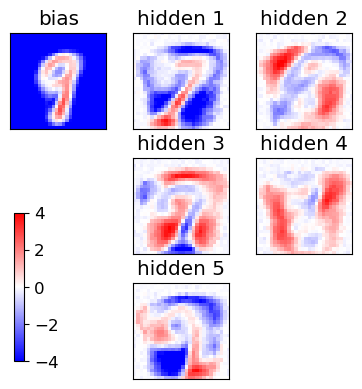

Epoch 61, Log-Likelihood: -159.93048458809213
epoch 61 / 150  Nt: 6  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 6  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 6  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 6  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 6  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -155.34790716613236
epoch 66 / 150  Nt: 6  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 6  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 6  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 6  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 6  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -155.43299862905255
epoch 

<Figure size 640x480 with 0 Axes>

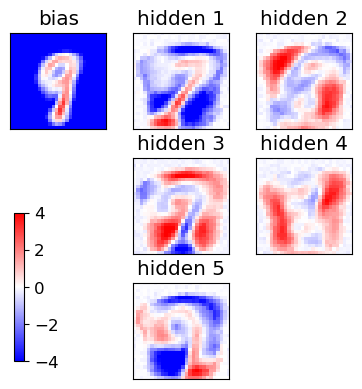

Epoch 81, Log-Likelihood: -153.87957879029918
epoch 81 / 150  Nt: 6  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 6  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 6  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 6  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 6  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -155.54127171905657
epoch 86 / 150  Nt: 6  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 6  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 6  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 6  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 6  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -155.79426916262804
ep

<Figure size 640x480 with 0 Axes>

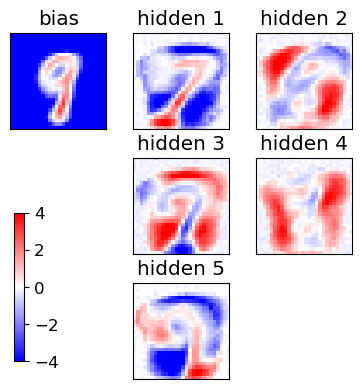

Epoch 101, Log-Likelihood: -155.59391377929603
epoch 101 / 150  Nt: 6  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 6  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 6  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 6  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 6  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -152.1702664476327
epoch 106 / 150  Nt: 6  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 6  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 6  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 6  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 6  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -152.01462

<Figure size 640x480 with 0 Axes>

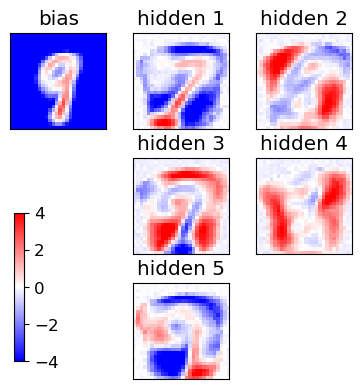

Epoch 121, Log-Likelihood: -153.07026166299264
epoch 121 / 150  Nt: 6  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 6  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 6  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 6  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 6  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -152.9159992155015
epoch 126 / 150  Nt: 6  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 6  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 6  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 6  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 6  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -152.32413

<Figure size 640x480 with 0 Axes>

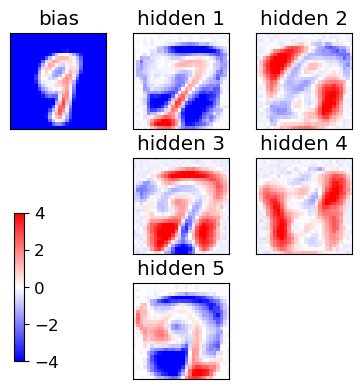

Epoch 141, Log-Likelihood: -153.44468056565577
epoch 141 / 150  Nt: 6  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 6  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 6  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 6  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 6  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -152.39544168893414
epoch 146 / 150  Nt: 6  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 6  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 6  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 6  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 6  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

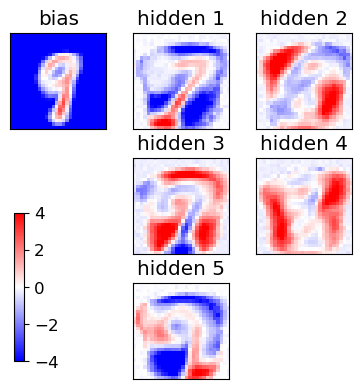

Epoch 151, Log-Likelihood: -152.7211484725691


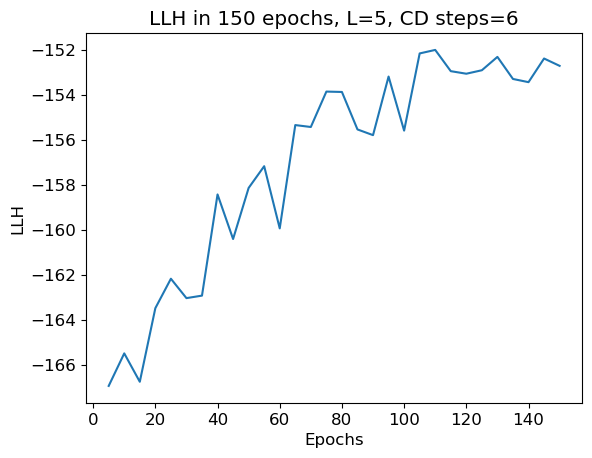

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

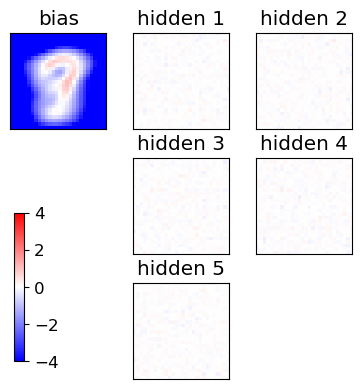

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[11152 13871  7454 17837 18894   320 18650 17648  2424 11524]
[13851  8651 10437  3154  4527  6976 16208  8261 18542 14856]
[15476  7661 19898 14204  1315 16354 12695 11971  1114  2491]
epoch 1 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -168.5407030935345
epoch 6 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 8  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 8  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150 

<Figure size 640x480 with 0 Axes>

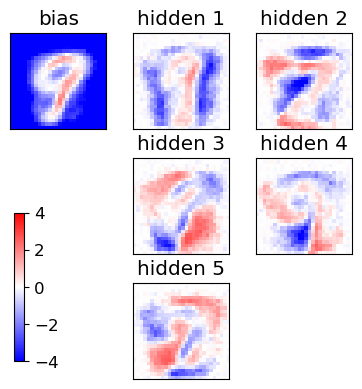

Epoch 21, Log-Likelihood: -157.31302617811923
epoch 21 / 150  Nt: 8  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 8  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 8  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 8  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 8  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -157.37969592842754
epoch 26 / 150  Nt: 8  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 8  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 8  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 8  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 8  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -158.09980164134186
epoch 31 / 1

<Figure size 640x480 with 0 Axes>

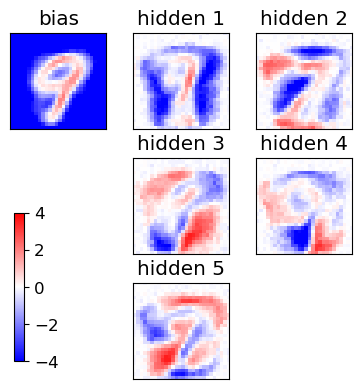

Epoch 41, Log-Likelihood: -159.31672473777908
epoch 41 / 150  Nt: 8  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 8  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 8  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 8  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 8  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -154.48095301141916
epoch 46 / 150  Nt: 8  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 8  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 8  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 8  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 8  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -156.60762726431545
epoch 51 / 1

<Figure size 640x480 with 0 Axes>

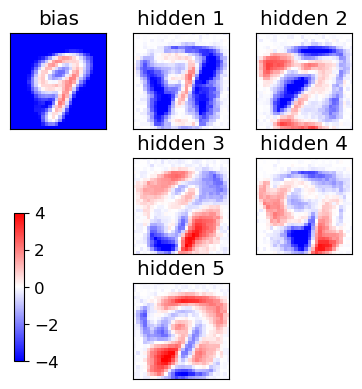

Epoch 61, Log-Likelihood: -157.16807798911003
epoch 61 / 150  Nt: 8  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 8  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 8  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 8  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 8  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -155.8339214944862
epoch 66 / 150  Nt: 8  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 8  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 8  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 8  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 8  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -161.21244558511674
epoch 7

<Figure size 640x480 with 0 Axes>

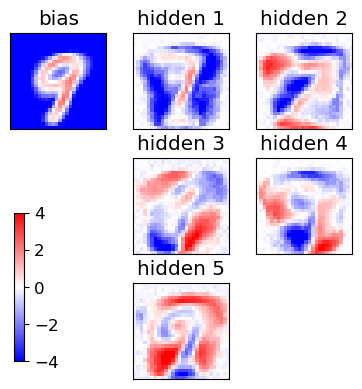

Epoch 81, Log-Likelihood: -157.17244429781226
epoch 81 / 150  Nt: 8  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 8  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 8  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 8  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 8  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -157.10141603461514
epoch 86 / 150  Nt: 8  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 8  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 8  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 8  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 8  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -155.03652237454918
ep

<Figure size 640x480 with 0 Axes>

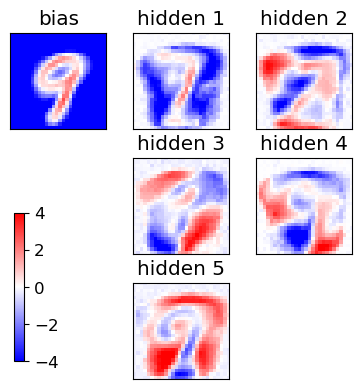

Epoch 101, Log-Likelihood: -155.561132601193
epoch 101 / 150  Nt: 8  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 8  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 8  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 8  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 8  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -155.29468564010097
epoch 106 / 150  Nt: 8  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 8  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 8  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 8  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 8  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -156.408725

<Figure size 640x480 with 0 Axes>

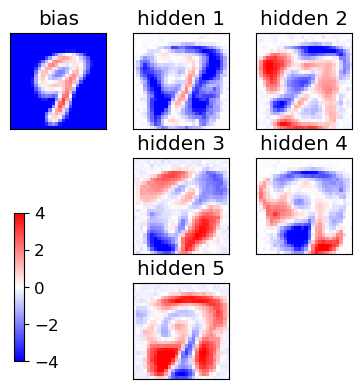

Epoch 121, Log-Likelihood: -154.2135868649051
epoch 121 / 150  Nt: 8  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 8  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 8  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 8  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 8  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -154.4096626396915
epoch 126 / 150  Nt: 8  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 8  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 8  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 8  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 8  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -154.301790

<Figure size 640x480 with 0 Axes>

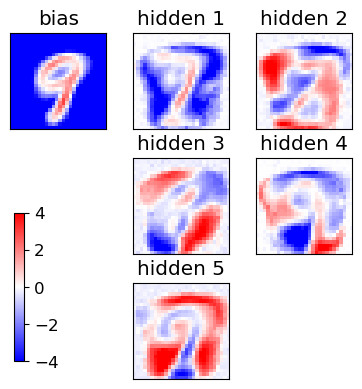

Epoch 141, Log-Likelihood: -153.18039378006307
epoch 141 / 150  Nt: 8  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 8  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 8  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 8  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 8  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -152.90640745323714
epoch 146 / 150  Nt: 8  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 8  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 8  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 8  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 8  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

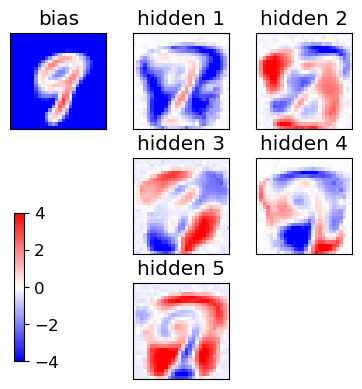

Epoch 151, Log-Likelihood: -152.23672003944517


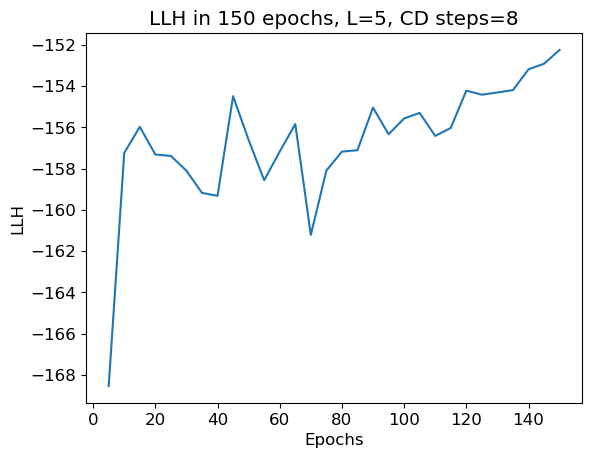

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

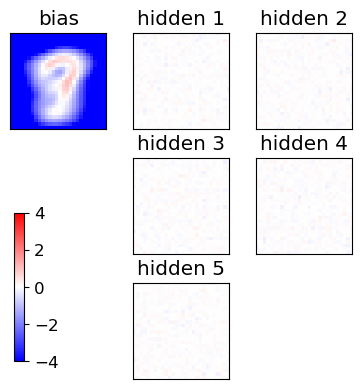

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[19290  2066   767  3504  7398  6858  8804  4713  2371 13834]
[15464  9049 19990 12446   632   512 15125 15016 16131  1018]
[ 4607 15931  9407 11934  1459  7553  1177  1217  5151  2085]
epoch 1 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -164.05567208717025
epoch 6 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 10  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 10  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch

<Figure size 640x480 with 0 Axes>

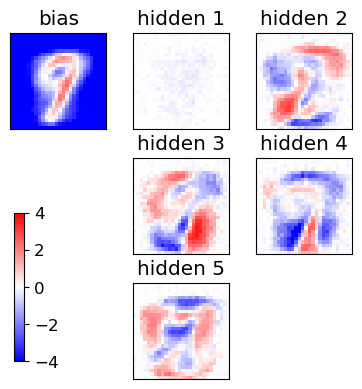

Epoch 21, Log-Likelihood: -159.46481752518923
epoch 21 / 150  Nt: 10  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 10  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 10  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 10  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 10  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -159.67222968449644
epoch 26 / 150  Nt: 10  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 10  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 10  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 10  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 10  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -158.88664904922445
ep

<Figure size 640x480 with 0 Axes>

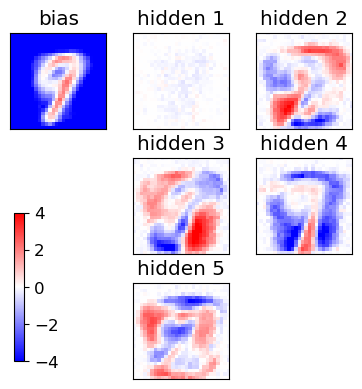

Epoch 41, Log-Likelihood: -158.81799527405656
epoch 41 / 150  Nt: 10  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 10  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 10  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 10  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 10  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -155.88897800201704
epoch 46 / 150  Nt: 10  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 10  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 10  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 10  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 10  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -155.5645338762799
epo

<Figure size 640x480 with 0 Axes>

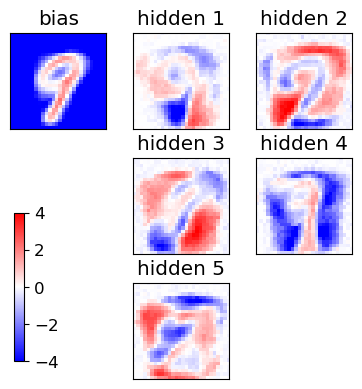

Epoch 61, Log-Likelihood: -153.4891132011686
epoch 61 / 150  Nt: 10  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 10  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 10  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 10  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 10  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -154.69825819364075
epoch 66 / 150  Nt: 10  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 10  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 10  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 10  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 10  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -155.713872353718

<Figure size 640x480 with 0 Axes>

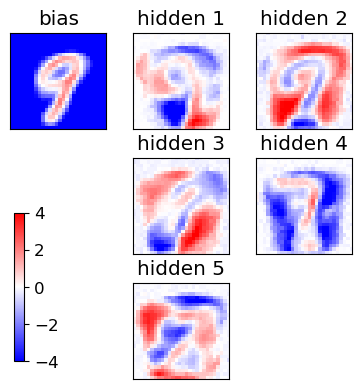

Epoch 81, Log-Likelihood: -152.53100174462702
epoch 81 / 150  Nt: 10  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 10  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 10  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 10  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 10  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -154.21729135047957
epoch 86 / 150  Nt: 10  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 10  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 10  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 10  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 10  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -154.8914303

<Figure size 640x480 with 0 Axes>

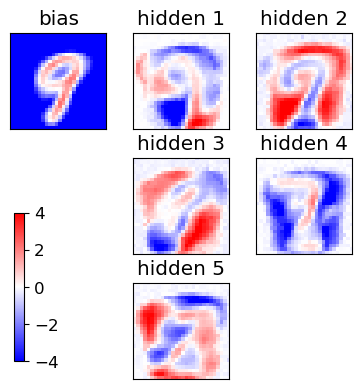

Epoch 101, Log-Likelihood: -155.49818849227583
epoch 101 / 150  Nt: 10  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 10  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 10  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 10  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 10  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -155.27154592096645
epoch 106 / 150  Nt: 10  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 10  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 10  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 10  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 10  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood:

<Figure size 640x480 with 0 Axes>

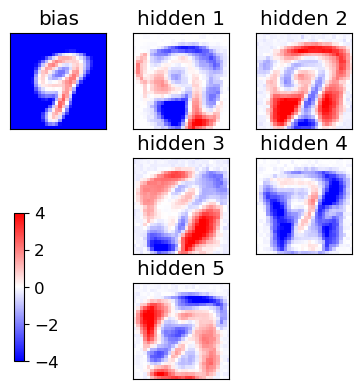

Epoch 121, Log-Likelihood: -153.1402161532674
epoch 121 / 150  Nt: 10  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 10  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 10  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 10  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 10  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -152.41858817874933
epoch 126 / 150  Nt: 10  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 10  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 10  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 10  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 10  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: 

<Figure size 640x480 with 0 Axes>

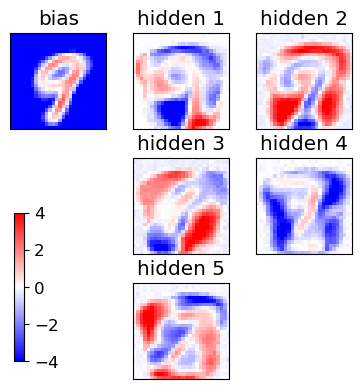

Epoch 141, Log-Likelihood: -151.20257554774813
epoch 141 / 150  Nt: 10  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 10  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 10  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 10  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 10  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -153.25240986084512
epoch 146 / 150  Nt: 10  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 10  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 10  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 10  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 10  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

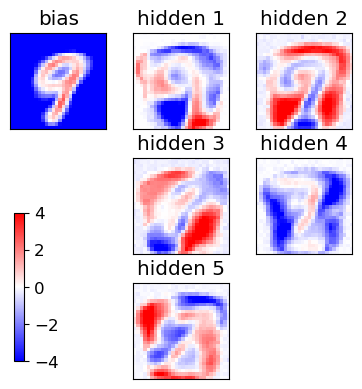

Epoch 151, Log-Likelihood: -151.79101656080948


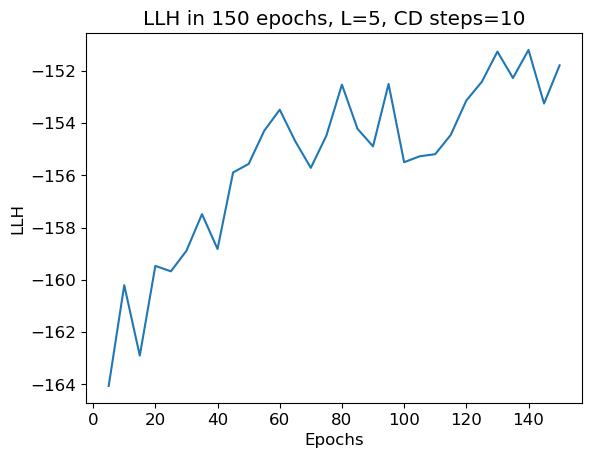

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

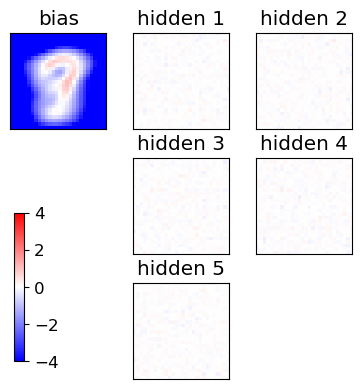

Starting the training
[ 6491  3886  3074 17240 11396  8449 14345 13555  7387  3867]
[ 4755  9825 15485 15568  9491  3462  2677 11698 19288 12053]
[  783 17676  4985  1618 16054  3542  1813 12757 13085  5867]
[15699   211  1305 14350  4725  5852 10521 20207 13737  7472]
epoch 1 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -168.59443910277497
epoch 6 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 12  N: 10  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 12  N: 11  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch

<Figure size 640x480 with 0 Axes>

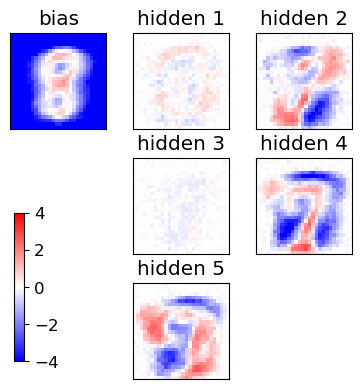

Epoch 21, Log-Likelihood: -162.95912841351458
epoch 21 / 150  Nt: 12  N: 18  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 12  N: 19  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 12  N: 20  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 12  N: 21  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 12  N: 22  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -157.38379452886412
epoch 26 / 150  Nt: 12  N: 23  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 12  N: 24  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 12  N: 26  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 12  N: 27  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 12  N: 28  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -155.59961653483094
ep

<Figure size 640x480 with 0 Axes>

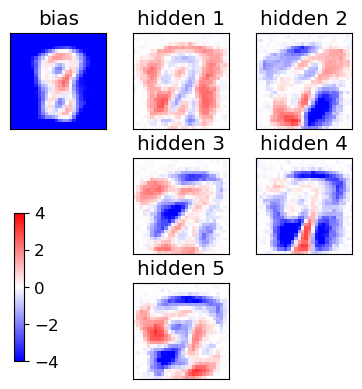

Epoch 41, Log-Likelihood: -156.2488641406355
epoch 41 / 150  Nt: 12  N: 45  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 12  N: 47  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 12  N: 48  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 12  N: 50  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 12  N: 52  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -158.59689542339007
epoch 46 / 150  Nt: 12  N: 54  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 12  N: 56  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 12  N: 58  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 12  N: 60  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 12  N: 62  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -154.65889038510417
epo

<Figure size 640x480 with 0 Axes>

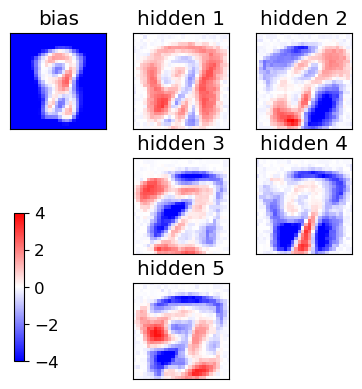

Epoch 61, Log-Likelihood: -152.45097188570182
epoch 61 / 150  Nt: 12  N: 89  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 12  N: 92  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 12  N: 94  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 12  N: 97  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 12  N: 100  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -151.66407683037176
epoch 66 / 150  Nt: 12  N: 103  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 12  N: 106  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 12  N: 109  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 12  N: 112  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 12  N: 115  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -153.56112084878

<Figure size 640x480 with 0 Axes>

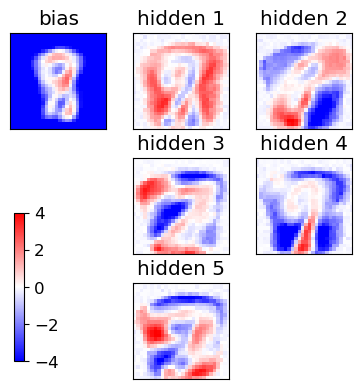

Epoch 81, Log-Likelihood: -152.59229097736664
epoch 81 / 150  Nt: 12  N: 151  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 12  N: 154  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 12  N: 158  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 12  N: 162  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 12  N: 165  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -153.58826696396784
epoch 86 / 150  Nt: 12  N: 169  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 12  N: 173  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 12  N: 177  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 12  N: 180  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 12  N: 184  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -155.4141523

<Figure size 640x480 with 0 Axes>

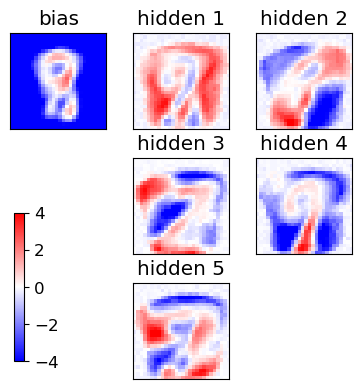

Epoch 101, Log-Likelihood: -152.48118949978422
epoch 101 / 150  Nt: 12  N: 230  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 12  N: 235  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 12  N: 239  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 12  N: 244  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 12  N: 248  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -152.80773680784168
epoch 106 / 150  Nt: 12  N: 253  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 12  N: 257  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 12  N: 262  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 12  N: 267  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 12  N: 272  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood:

<Figure size 640x480 with 0 Axes>

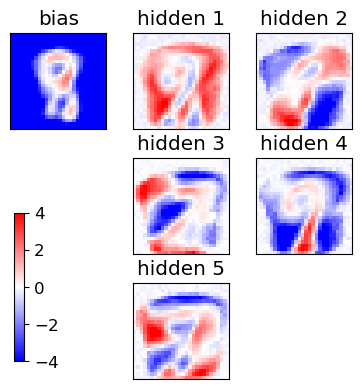

Epoch 121, Log-Likelihood: -151.4793932414516
epoch 121 / 150  Nt: 12  N: 327  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 12  N: 333  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 12  N: 338  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 12  N: 343  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 12  N: 349  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -152.86772077718373
epoch 126 / 150  Nt: 12  N: 354  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 12  N: 360  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 12  N: 365  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 12  N: 371  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 12  N: 377  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: 

<Figure size 640x480 with 0 Axes>

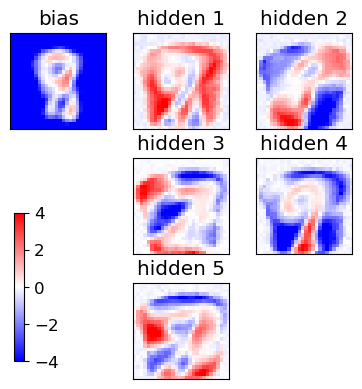

Epoch 141, Log-Likelihood: -153.57974007214526
epoch 141 / 150  Nt: 12  N: 442  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 12  N: 448  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 12  N: 455  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 12  N: 461  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 12  N: 467  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -150.94830622801305
epoch 146 / 150  Nt: 12  N: 474  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 12  N: 480  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 12  N: 486  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 12  N: 493  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 12  N: 500  L: 5  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

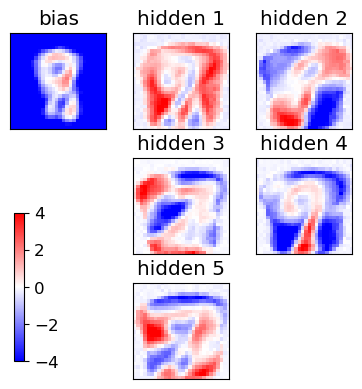

Epoch 151, Log-Likelihood: -150.49754403166247


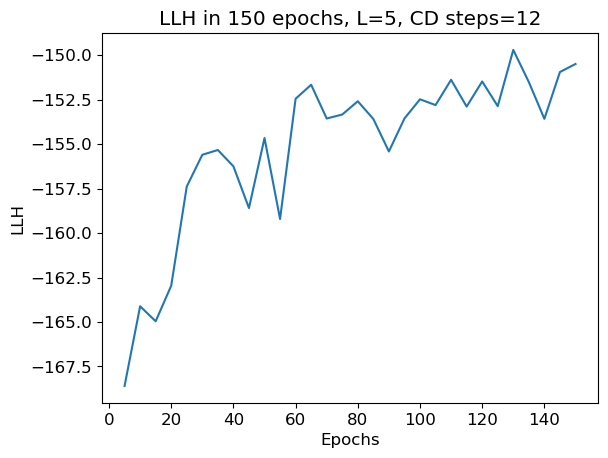

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

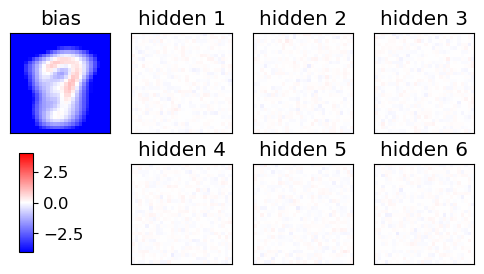

Starting the training
[ 2834 16443 18114   584 15965 14440 11162 16226 20688  4526]
[ 1493  3841  3274 15743 14817 15947 19918  2378  1734  1425]
[18181 10284   396 11772  7133  4653  6955 12818 18248  2675]
[12836  3027 10353 18767  9352  8094  6345 10424  7723  8447]
epoch 1 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -168.12416487481974
epoch 6 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 2  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 2  N: 11  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

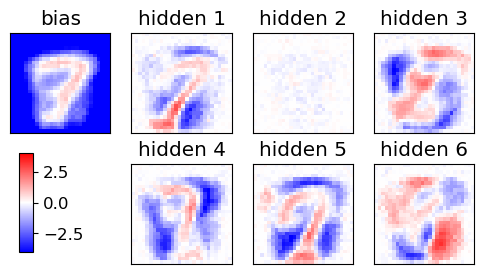

Epoch 21, Log-Likelihood: -156.68642359792977
epoch 21 / 150  Nt: 2  N: 18  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 2  N: 19  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 2  N: 20  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 2  N: 21  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 2  N: 22  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -156.97804619325348
epoch 26 / 150  Nt: 2  N: 23  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 2  N: 24  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 2  N: 26  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 2  N: 27  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 2  N: 28  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -153.81411014853907
epoch 31 / 1

<Figure size 640x480 with 0 Axes>

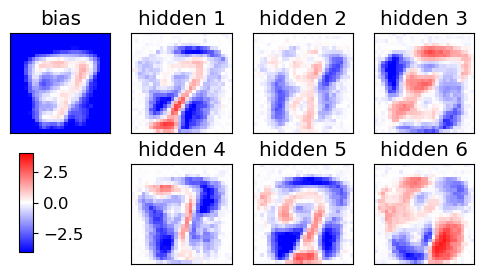

Epoch 41, Log-Likelihood: -155.95143631131037
epoch 41 / 150  Nt: 2  N: 45  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 2  N: 47  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 2  N: 48  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 2  N: 50  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 2  N: 52  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -155.4066234294119
epoch 46 / 150  Nt: 2  N: 54  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 2  N: 56  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 2  N: 58  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 2  N: 60  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 2  N: 62  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -157.02914532779988
epoch 51 / 15

<Figure size 640x480 with 0 Axes>

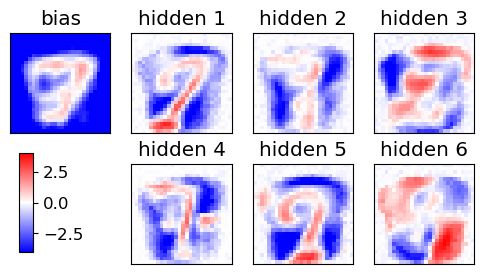

Epoch 61, Log-Likelihood: -155.44232507170085
epoch 61 / 150  Nt: 2  N: 89  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 2  N: 92  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 2  N: 94  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 2  N: 97  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 2  N: 100  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -155.37912560609482
epoch 66 / 150  Nt: 2  N: 103  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 2  N: 106  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 2  N: 109  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 2  N: 112  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 2  N: 115  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -152.9451380196227
epoch 7

<Figure size 640x480 with 0 Axes>

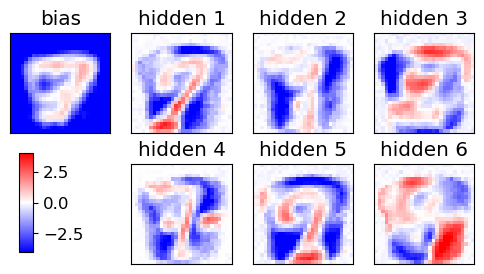

Epoch 81, Log-Likelihood: -156.35383097623185
epoch 81 / 150  Nt: 2  N: 151  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 2  N: 154  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 2  N: 158  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 2  N: 162  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 2  N: 165  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -150.46756228280714
epoch 86 / 150  Nt: 2  N: 169  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 2  N: 173  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 2  N: 177  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 2  N: 180  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 2  N: 184  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -152.36020392113258
ep

<Figure size 640x480 with 0 Axes>

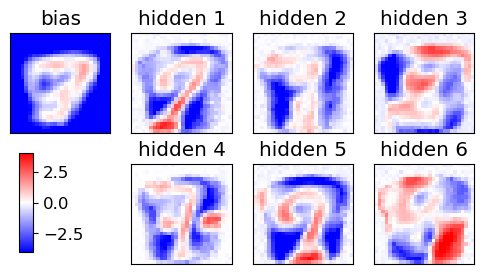

Epoch 101, Log-Likelihood: -150.25799512376685
epoch 101 / 150  Nt: 2  N: 230  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 2  N: 235  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 2  N: 239  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 2  N: 244  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 2  N: 248  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -150.64092266759636
epoch 106 / 150  Nt: 2  N: 253  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 2  N: 257  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 2  N: 262  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 2  N: 267  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 2  N: 272  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -147.2422

<Figure size 640x480 with 0 Axes>

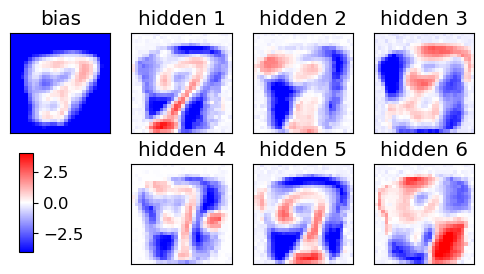

Epoch 121, Log-Likelihood: -146.6894008013351
epoch 121 / 150  Nt: 2  N: 327  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 2  N: 333  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 2  N: 338  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 2  N: 343  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 2  N: 349  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -147.46205098460027
epoch 126 / 150  Nt: 2  N: 354  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 2  N: 360  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 2  N: 365  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 2  N: 371  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 2  N: 377  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -147.47891

<Figure size 640x480 with 0 Axes>

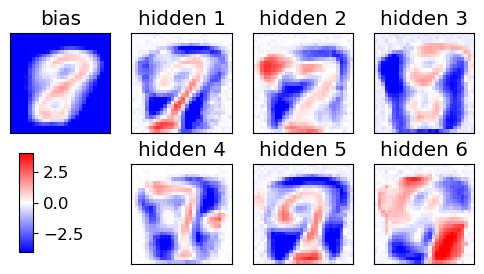

Epoch 141, Log-Likelihood: -153.58829819329392
epoch 141 / 150  Nt: 2  N: 442  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 2  N: 448  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 2  N: 455  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 2  N: 461  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 2  N: 467  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -152.13384808888443
epoch 146 / 150  Nt: 2  N: 474  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 2  N: 480  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 2  N: 486  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 2  N: 493  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 2  N: 500  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

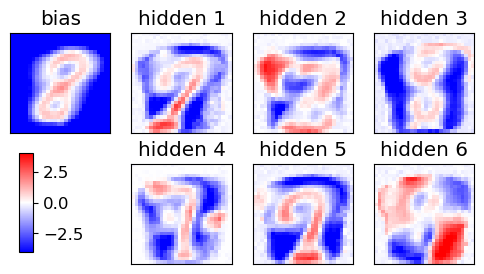

Epoch 151, Log-Likelihood: -152.05250468308125


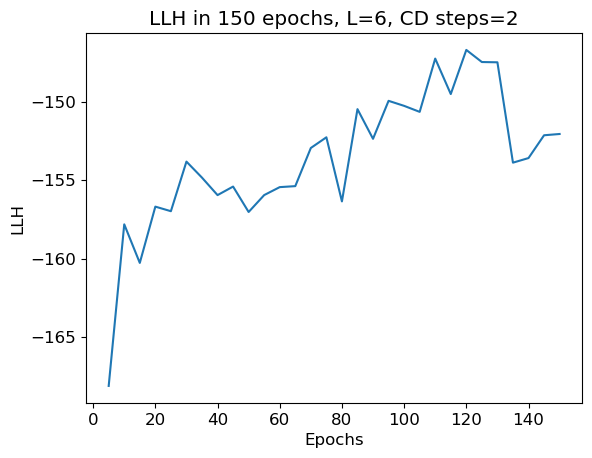

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

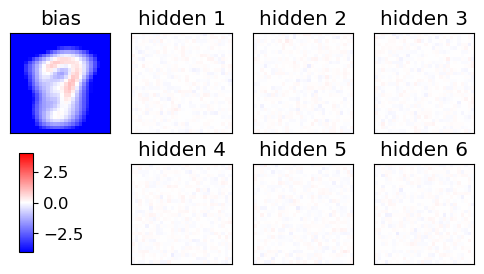

Starting the training
[ 2834 16443 18114   584 15965 14440 11162 16226 20688  4526]
[19394  2635  1336 18089 11405   825 18622 14583 13307  2684]
[10917 15248 20250  3549 12532  1038 17361 16662  6854  2862]
[ 5828  1188  2253  5257  1312   433 20330  6564  2971 10481]
epoch 1 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -166.66723590103285
epoch 6 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 4  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 4  N: 11  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

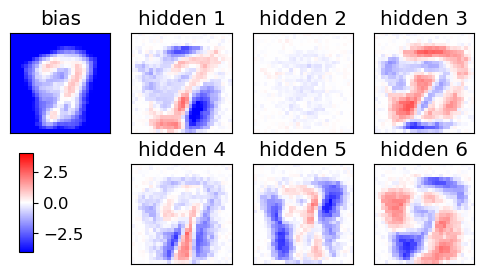

Epoch 21, Log-Likelihood: -156.74428079802112
epoch 21 / 150  Nt: 4  N: 18  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 4  N: 19  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 4  N: 20  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 4  N: 21  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 4  N: 22  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -156.2982210032787
epoch 26 / 150  Nt: 4  N: 23  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 4  N: 24  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 4  N: 26  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 4  N: 27  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 4  N: 28  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -156.78520640881206
epoch 31 / 15

<Figure size 640x480 with 0 Axes>

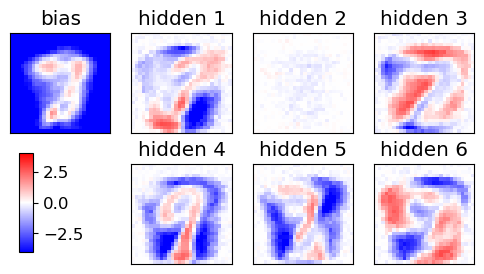

Epoch 41, Log-Likelihood: -155.43342443096068
epoch 41 / 150  Nt: 4  N: 45  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 4  N: 47  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 4  N: 48  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 4  N: 50  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 4  N: 52  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -156.68205635812066
epoch 46 / 150  Nt: 4  N: 54  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 4  N: 56  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 4  N: 58  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 4  N: 60  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 4  N: 62  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -160.16977459644207
epoch 51 / 1

<Figure size 640x480 with 0 Axes>

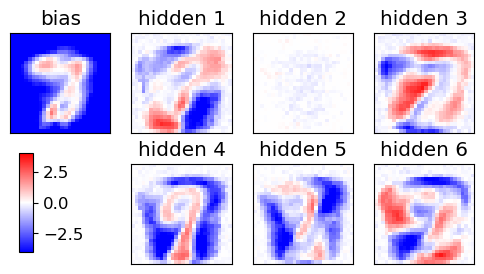

Epoch 61, Log-Likelihood: -153.54900204963377
epoch 61 / 150  Nt: 4  N: 89  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 4  N: 92  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 4  N: 94  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 4  N: 97  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 4  N: 100  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -154.9754617855725
epoch 66 / 150  Nt: 4  N: 103  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 4  N: 106  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 4  N: 109  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 4  N: 112  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 4  N: 115  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -154.0947313333955
epoch 71

<Figure size 640x480 with 0 Axes>

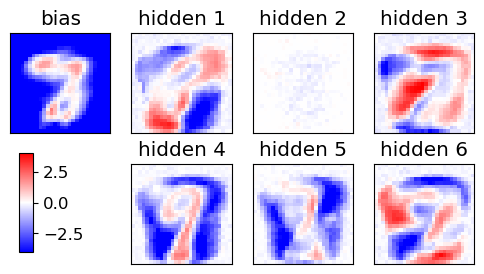

Epoch 81, Log-Likelihood: -157.58490851209993
epoch 81 / 150  Nt: 4  N: 151  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 4  N: 154  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 4  N: 158  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 4  N: 162  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 4  N: 165  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -155.01360730938313
epoch 86 / 150  Nt: 4  N: 169  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 4  N: 173  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 4  N: 177  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 4  N: 180  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 4  N: 184  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -153.12047759666723
ep

<Figure size 640x480 with 0 Axes>

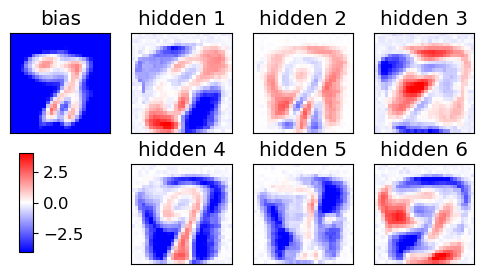

Epoch 101, Log-Likelihood: -153.6907707925498
epoch 101 / 150  Nt: 4  N: 230  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 4  N: 235  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 4  N: 239  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 4  N: 244  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 4  N: 248  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -152.34479906795772
epoch 106 / 150  Nt: 4  N: 253  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 4  N: 257  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 4  N: 262  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 4  N: 267  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 4  N: 272  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -151.20086

<Figure size 640x480 with 0 Axes>

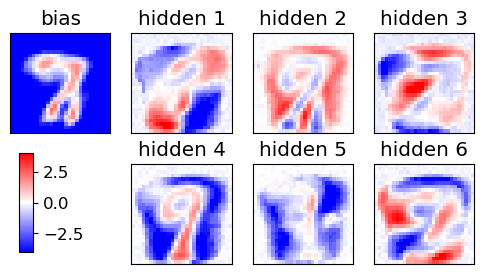

Epoch 121, Log-Likelihood: -151.97873468373325
epoch 121 / 150  Nt: 4  N: 327  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 4  N: 333  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 4  N: 338  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 4  N: 343  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 4  N: 349  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -153.62782509784023
epoch 126 / 150  Nt: 4  N: 354  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 4  N: 360  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 4  N: 365  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 4  N: 371  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 4  N: 377  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -154.3523

<Figure size 640x480 with 0 Axes>

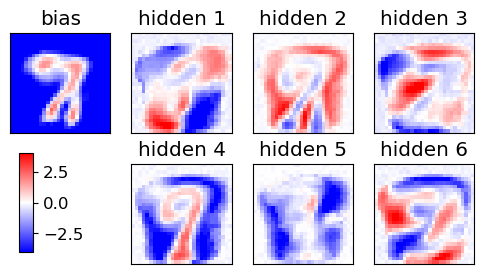

Epoch 141, Log-Likelihood: -151.26672495494228
epoch 141 / 150  Nt: 4  N: 442  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 150  Nt: 4  N: 448  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 150  Nt: 4  N: 455  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 150  Nt: 4  N: 461  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 150  Nt: 4  N: 467  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 146, Log-Likelihood: -151.68008766545188
epoch 146 / 150  Nt: 4  N: 474  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 150  Nt: 4  N: 480  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 150  Nt: 4  N: 486  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 150  Nt: 4  N: 493  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 150  Nt: 4  N: 500  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False


<Figure size 640x480 with 0 Axes>

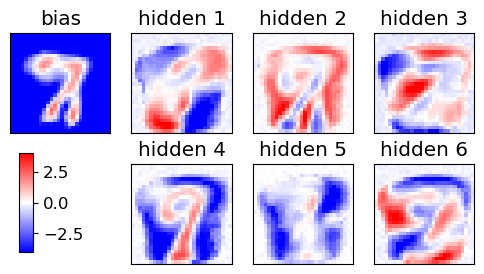

Epoch 151, Log-Likelihood: -151.35304574846592


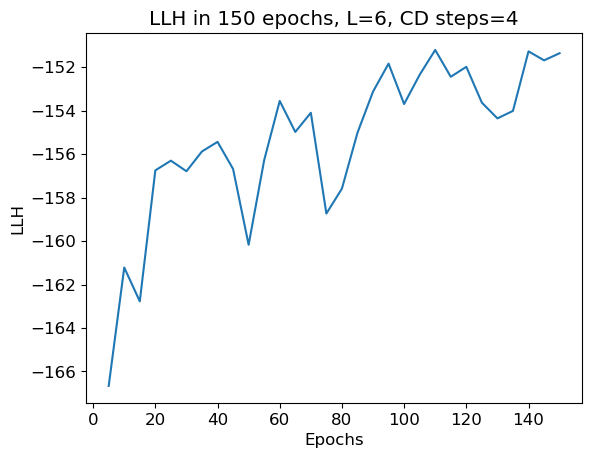

END of learning phase
Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

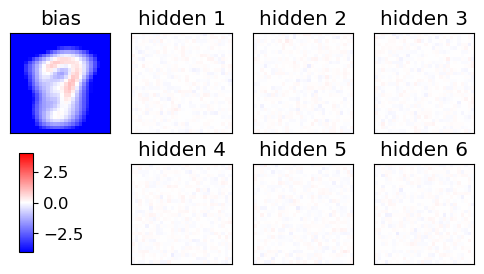

Starting the training
[ 2834 16443 18114   584 15965 14440 11162 16226 20688  4526]
[17576   668  8386 19437  5315  4223 12061 11983 13686  5488]
[17464  8419 11393 19937 18628   104  1680 20962  9175  6430]
[ 1991 14954  8449  1015 14806  6797   222 20862  4767  4561]
epoch 1 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 6, Log-Likelihood: -161.30007053105888
epoch 6 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 150  Nt: 6  N: 10  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 150  Nt: 6  N: 11  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 150

<Figure size 640x480 with 0 Axes>

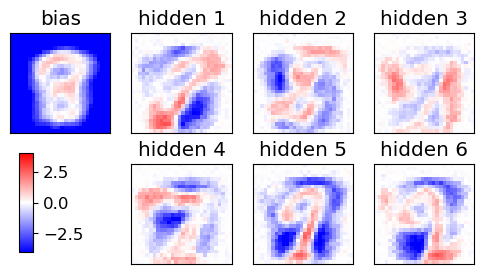

Epoch 21, Log-Likelihood: -152.91292822436768
epoch 21 / 150  Nt: 6  N: 18  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 150  Nt: 6  N: 19  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 150  Nt: 6  N: 20  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 150  Nt: 6  N: 21  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 150  Nt: 6  N: 22  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 26, Log-Likelihood: -155.00989209301835
epoch 26 / 150  Nt: 6  N: 23  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 150  Nt: 6  N: 24  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 150  Nt: 6  N: 26  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 150  Nt: 6  N: 27  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 150  Nt: 6  N: 28  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 31, Log-Likelihood: -155.70756556237987
epoch 31 / 1

<Figure size 640x480 with 0 Axes>

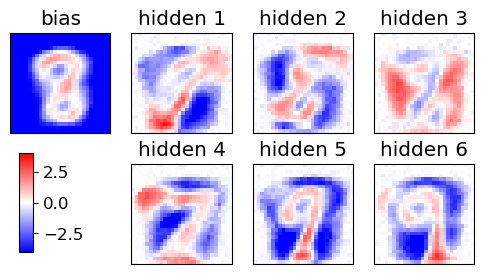

Epoch 41, Log-Likelihood: -157.00140198050775
epoch 41 / 150  Nt: 6  N: 45  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 150  Nt: 6  N: 47  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 150  Nt: 6  N: 48  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 150  Nt: 6  N: 50  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 150  Nt: 6  N: 52  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 46, Log-Likelihood: -156.03475747088115
epoch 46 / 150  Nt: 6  N: 54  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 150  Nt: 6  N: 56  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 150  Nt: 6  N: 58  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 150  Nt: 6  N: 60  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 150  Nt: 6  N: 62  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 51, Log-Likelihood: -155.53609852001867
epoch 51 / 1

<Figure size 640x480 with 0 Axes>

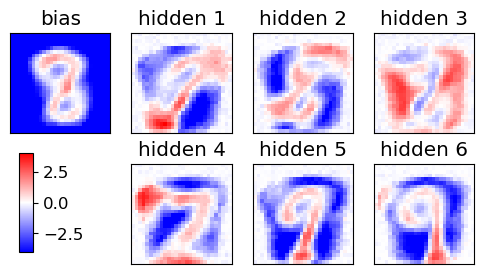

Epoch 61, Log-Likelihood: -154.06146679413442
epoch 61 / 150  Nt: 6  N: 89  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 150  Nt: 6  N: 92  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 150  Nt: 6  N: 94  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 150  Nt: 6  N: 97  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 150  Nt: 6  N: 100  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 66, Log-Likelihood: -157.65808891707178
epoch 66 / 150  Nt: 6  N: 103  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 150  Nt: 6  N: 106  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 150  Nt: 6  N: 109  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 150  Nt: 6  N: 112  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 150  Nt: 6  N: 115  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 71, Log-Likelihood: -154.7246572351044
epoch 7

<Figure size 640x480 with 0 Axes>

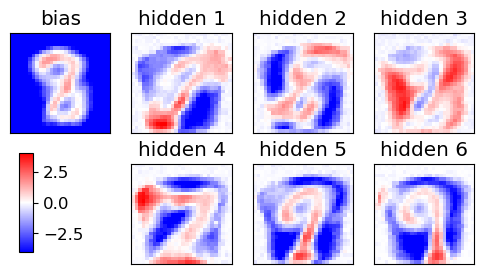

Epoch 81, Log-Likelihood: -154.5459720212009
epoch 81 / 150  Nt: 6  N: 151  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 150  Nt: 6  N: 154  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 150  Nt: 6  N: 158  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 150  Nt: 6  N: 162  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 150  Nt: 6  N: 165  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 86, Log-Likelihood: -150.80234900921798
epoch 86 / 150  Nt: 6  N: 169  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 150  Nt: 6  N: 173  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 150  Nt: 6  N: 177  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 150  Nt: 6  N: 180  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 150  Nt: 6  N: 184  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 91, Log-Likelihood: -152.22015047338743
epo

<Figure size 640x480 with 0 Axes>

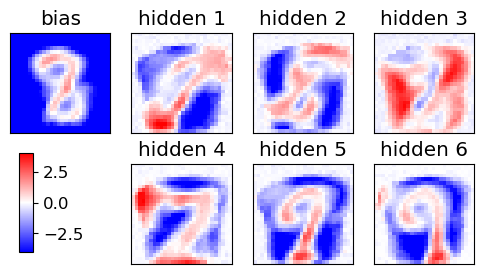

Epoch 101, Log-Likelihood: -151.3756207295986
epoch 101 / 150  Nt: 6  N: 230  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 150  Nt: 6  N: 235  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 150  Nt: 6  N: 239  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 150  Nt: 6  N: 244  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 150  Nt: 6  N: 248  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 106, Log-Likelihood: -150.8465320392269
epoch 106 / 150  Nt: 6  N: 253  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 150  Nt: 6  N: 257  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 150  Nt: 6  N: 262  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 150  Nt: 6  N: 267  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 150  Nt: 6  N: 272  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 111, Log-Likelihood: -151.513879

<Figure size 640x480 with 0 Axes>

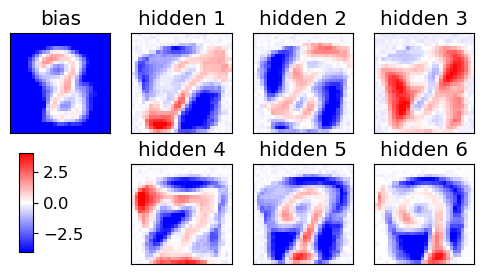

Epoch 121, Log-Likelihood: -153.22668048840524
epoch 121 / 150  Nt: 6  N: 327  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 150  Nt: 6  N: 333  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 150  Nt: 6  N: 338  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 150  Nt: 6  N: 343  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 150  Nt: 6  N: 349  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 126, Log-Likelihood: -151.46484231028788
epoch 126 / 150  Nt: 6  N: 354  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 150  Nt: 6  N: 360  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 150  Nt: 6  N: 365  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 150  Nt: 6  N: 371  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 150  Nt: 6  N: 377  L: 6  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
Epoch 131, Log-Likelihood: -150.9786

In [ ]:
for L in np.arange(3,12):
    for Nt in np.arange(2,14,2):
        # random seed for reproducibility
        np.random.seed(12345)

        # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
        w = sigma * np.random.randn(D,L)
        #a = sigma * np.random.randn(D)
        # using Hinton initialization of visible biases
        a = Hinton_bias_init(data)
        # hidden biases initialized to zero
        b = np.zeros(L)
        #print("w=",w);print("a=",a);print("b=",b)

        # nr of epochs
        Nepoch=150
        # minibatches per epoch
        Nmini=20  # TRIED VALUES : 20
        # minibatch size at initial epoch and final one
        N_ini,N_fin=10,500
        print(f"Nepoch={Nepoch}\nNmini={Nmini}")
        # number of CD steps
        #Nt=2 ###########################################################################################NT

        # recording history of weights ("E" means epoch)
        wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
        wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
        gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
        gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
        gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
        miniE = np.zeros(Nepoch+1)
        pzE=np.zeros((Nepoch+1,Nz))
        if GRAD=="RMSprop": 
            gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

        indices=np.arange(Nd).astype("int")
        plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)

        # for the plot with panels
        Ncols=min(8,max(2,L//2))

        if POTTS: print("Starting the training, POTTS=True")
        else: print("Starting the training")
        #for L in np.arange(4,9,1):


        log_likelihoods = []
        lista_epoch_grafico = []
        # Note: here an epoch does not analyze the whole dataset
        for epoch in range(1,1+Nepoch):
            # q maps epochs to interval [0,1]
            q = (epoch-1.)/(Nepoch-1.) 
            # N, size of the mini batch
            # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
            N = int(N_ini + (N_fin-N_ini)*(q**2))
            #  l_rate interpolates between initial and final value
            l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

            for mini in range(Nmini):
                # initializitation for averages in minibatch
                # visible variables "v" --> "x"
                #  hidden variables "h" --> "z"
                x_data, x_model = np.zeros(D),np.zeros(D)
                z_data, z_model = np.zeros(L),np.zeros(L)
                xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
                pz = np.zeros(L)

                # Minibatch of size N: points randomply picked (without repetition) from data
                selected = np.random.choice(indices,N,replace=False)
                if epoch==1 and mini<=3: print(selected)

                for k in range(N):
                    ###################################
                    x0 = data[selected[k]]
                    # positive CD phase: generating z from x[k]
                    z = CD_step(x0,w,b,POTTS=POTTS)
                    x_data  += x0
                    z_data  += z
                    xz_data += np.outer(x0,z)
                    # fantasy
                    zf=np.copy(z)
                    # Contrastive divergence with Nt steps
                    for t in range(Nt):
                        # negative CD pzase: generating fantasy xf from fantasy zf
                        xf = CD_step(zf,w.T,a)
                        # positive CD phase: generating fantasy zf from fantasy xf 
                        zf = CD_step(xf,w,b,POTTS=POTTS)
                    x_model += xf
                    z_model += zf
                    xz_model+= np.outer(xf,zf)
                    # recording probability of encoding in z-space, if POTTS
                    if POTTS: pz[zf]+=1
                    ###################################

                # gradient of the likelihood: follow it along its positive direction
                gw_d,gw_m = xz_data/N, xz_model/N
                ga_d,ga_m = x_data/N, x_model/N
                gb_d,gb_m = z_data/N, z_model/N
                gw=np.copy(gw_d - gw_m)
                ga=np.copy(ga_d - ga_m)
                gb=np.copy(gb_d - gb_m)

                # gradient ascent step
                if GRAD=="RMSprop":
                    # RMSprop gradient ascent
                    gw2 = beta*gw2+(1-beta)*np.square(gw)
                    ga2 = beta*ga2+(1-beta)*np.square(ga)
                    gb2 = beta*gb2+(1-beta)*np.square(gb)
                    w += l_rate*gw/sqrt(epsilon+gw2)
                    a += l_rate*ga/sqrt(epsilon+ga2)
                    b += l_rate*gb/sqrt(epsilon+gb2)
                else: 
                    # defaulting to the vanilla stochastic gradient ascent (SGD)
                    w += l_rate*gw
                    a += l_rate*ga
                    b += l_rate*gb
                # regularization (LASSO)
                if gamma>0.:
                    w -= (gamma*l_rate)*sign(w)
                    a -= (gamma*l_rate)*sign(a)
                    b -= (gamma*l_rate)*sign(b)

            wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
            aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
            bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
            miniE[epoch]=N
            if POTTS: pzE[epoch] = pz/np.sum(pz)
            print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
                  " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)

            if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
                plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)

            if epoch%5==0:
                partition = partition_function()
                log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,)
                log_likelihoods.append(log_likelihood)
                lista_epoch_grafico.append(epoch)
                print(f'Epoch {epoch + 1}, Log-Likelihood: {log_likelihood}')

            str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")


        plt.plot(lista_epoch_grafico, log_likelihoods, '-')
        plt.title(f'LLH in {Nepoch} epochs, L={L}, CD steps={Nt}')
        plt.xlabel('Epochs')
        plt.ylabel('LLH')
        plt.savefig(f'img/LLH_epoch{Nepoch}_L{L}_CD{Nt}_lr{l_rate}.png')
        plt.show()
        print("END of learning phase")

## Test generative power of the trained RBM

In [ ]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

In [ ]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\\sim 1 / \\sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [ ]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

In [ ]:
Nd

# RESULTS

#### 1. Initialization of biases

Explain the initialization of visible biases proposed by Hinton.

#### 2. Log-likelihood

Take an RBM with L=3 hidden units and compute the log-likelihood L of data during training (see the notes). Does it grow during training? Does it depend on the number of contrastive divergence steps?  Then compare the log-likelihood L at the end of training for L=3, 4, 5, 6, … up to a maximum L of your choice.

For L=3, contrastive divergence steps: 2

![LLHscoreL3CD2](img/LLH_standard_L3_CD2.png)

For L=3, contrastive divergence steps: 3

![LLHscoreL3CD3](img/LLH_standard_L3_CD3.png)

L=3, contrastive divergence steps: 4

![LLHscoreL3CD4](img/LLH_standard_L3_CD4.png)

L=3, contrastive divergence steps: 5

![LLHscoreL3CD3](img/LLH_standard_L3_CD5.png)

L=3, contrastive divergence steps: 7

![LLHscoreL3CD3](img/LLH_standard_L3_CD7.png)

L=3, contrastive divergence steps: 10

![LLHscoreL3CD3](img/LLH_standard_L3_CD10.png)

L=3 , contrastive divergence steps:15

![LLHscoreL3CD3](img/LLH_standard_L3_CD15.png)


In [ ]:
![LLH score, 150 epochs, L=4](img/LLH_standard_L4.png)
![LLH score, 150 epochs, L=5](img/LLH_standard_L5.png)
![LLH score, 150 epochs, L=6](img/LLH_standard_L6.png)
![LLH score, 150 epochs, L=7](img/LLH_standard_L7.png)
![LLH score, 150 epochs, L=8](img/LLH_standard_L8.png)

In [ ]:
for i in [3]:
    print(i)